In [1]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colorbar import ColorbarBase


In [2]:



''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def universal_func_old_emissivity(So=2000, Fo=50, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),RH1 =0.9, RH2 = 0.8, RH3 = 0.3,debug=False):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cpd = 1005.7 #J/kgK #heat capacity
        Cpv = 1996 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization
        
        #RH1 = 0.9 #Relative Humidity
        #RH2 = 0.8 
        #RH3 = 0.3
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        ws_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        w_1 = RH1 * ws_1
        q1 = w_1/(1+w_1)
        q1_s = ws_1/(1+ws_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1
        Cp2 = Cpd*(1 - q2) + Cpv * q2
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        #k3 = 0.08 # relates the strength of convection to the cloud fraction
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        def tau(T,Tft):
            tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
            return tau
            
        #epsilon_2 = 1/(1+tau(T2,273))
        #epsilon_3 = 1/(1+tau(T3,273))
        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux = epsilon_2*sigma*T2**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night,Flux)
        
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations,p_guess,full_output=True)
    if ier==1:
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux = equations((T1, T2, T3, T4, Fa, Fc))
    if debug==False:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night)
    else:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,info,ier,msg)

In [3]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt



''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def universal_func(So=2000, Fo=50, mm_dry = 0.028, assumption = 'WTG', p_guess=(300,270,270,300,200,20),RH1 =0.9, RH2 = 0.8, RH3 = 0.3,debug=False):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cpd = 1005.7 #J/kgK #heat capacity
        Cpv = 1996 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization
        
        
        
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        ws_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        w_1 = RH1 * ws_1
        q1 = w_1/(1+w_1)
        q1_s = ws_1/(1+ws_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        '''
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        '''
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1
        Cp2 = Cpd*(1 - q2) + Cpv * q2
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport
        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 10 # Relates water vapor to the infrared opacity 
    
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        def tau(T,Tft):
            tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
            return tau
            
        epsilon_2_tau = 1/(1+tau(T2,273))
        epsilon_3_tau = 1/(1+tau(T3,273))
        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2_tau*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2_tau*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3_tau*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3_tau*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2_tau*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3_tau*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night)
        
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations,p_guess,full_output=True)
    if ier==1:
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night = equations((T1, T2, T3, T4, Fa, Fc))
    if debug==False:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night)
    else:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,info,ier,msg)

In [4]:
#RH = np.linspace(0,1,100)
universal_func(assumption='WBG', p_guess = (311.397666555272, 297.48929890880356, 301.9543627737432, 300, 1.0178964527851988e-22, 131.77987239320674), RH3=0.1)


<ipython-input-3-9d9084043c2c>:93: RuntimeWarning: invalid value encountered in log
  fc = k3*np.log(Fc+1.0)


(311.397666555272,
 297.48929890880356,
 301.9543627737432,
 300.0,
 1.0178964527851988e-22,
 131.77987239320674,
 0.39109541298010314,
 0.041153401620583945,
 0.02720019767251494,
 0.004631045420476479,
 0.4458968258118939,
 0.23814724488515204,
 0.04525448858259873,
 450.35699399042903,
 670.839040326401)

In [5]:
# calculate matrix for heatmap
nrh = 100
nso = 100
RH3 = np.linspace(0.01,0.81,nrh)
so = np.linspace(1000,3000,nso)
xlab = 'Stellar Flux' 
xunit = '(W/$m^2$)'
ylab = 'Relative Humidity' 
yunit = ''



fig = plt.figure(figsize = (12,10))
for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
    OLR_day_matrix = np.zeros((nrh, nso))
    OLR_night_matrix = np.zeros((nrh, nso))

    nele = len(RH3)
    initial_guess = (250,250,200,200,200,20)
    for irh,rh in enumerate(RH3):
        #print(idx,s)
        for iso,s in enumerate(so):
            T1, T2, T3, T4, Fa, Fc,fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night= universal_func(So = s, RH3 = rh, assumption  = assumption, p_guess = initial_guess)
            OLR_day_matrix[irh, iso] = OLR_day
            OLR_night_matrix[irh, iso] = OLR_night
            initial_guess = (T1, T2, T3, T4, Fa, Fc)
    if i_assump == 0:
        OLR_day_WTG = OLR_day_matrix
        OLR_night_WTG = OLR_night_matrix
    elif i_assump == 1:
        OLR_day_WBG = OLR_day_matrix
        OLR_night_WBG = OLR_night_matrix

    #nele = len(arr_list)
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    #unit_list = [r'($\frac{W}{m^2}$)',r'($\frac{W}{m^2}$)','','', '','']


We have a solution:  (196.42150879877178, 170.24722126392842, 170.24722126392842, 202.7431174109333, 76.33407924234136, 211.0572689100959)
We have a solution:  (198.04201043772622, 171.6526208912565, 171.6526208912565, 203.54841103373158, 78.88602276886995, 213.73506340023317)
We have a solution:  (199.62288846524913, 173.02384818854554, 173.02384818854554, 204.34397993756187, 81.4370673848195, 216.39959422185154)
We have a solution:  (201.16625921499084, 174.36276171809612, 174.36276171809612, 205.13008753525187, 83.98721069546393, 219.05124798361834)
We have a solution:  (202.67406090881073, 175.67106780134847, 175.67106780134847, 205.90698734038745, 86.53645425901777, 221.69040223897238)
We have a solution:  (204.14807290956807, 176.9503372588304, 176.9503372588304, 206.6749235337623, 89.08480358617774, 224.31742687458762)
We have a solution:  (205.58993236277576, 178.20201988076747, 178.20201988076747, 207.43413147921564, 91.63226812027087, 226.93268529977894)
We have a solution:  

We have a solution:  (198.04201101252417, 171.65262138979006, 171.65262138979006, 203.54841115713808, 78.8860221161918, 213.73506268640452)
We have a solution:  (199.62288919756455, 173.02384882379332, 173.02384882379332, 204.3439800968688, 81.4370665343573, 216.39959329190657)
We have a solution:  (201.16626013944096, 174.36276252015327, 174.36276252015327, 205.13008773891102, 83.98720959824259, 219.05124678408845)
We have a solution:  (202.67406206582243, 175.67106880538321, 175.67106880538321, 205.9069875983943, 86.53645285651584, 221.69040070597816)
We have a solution:  (204.14807434605734, 176.95033850568618, 176.95033850568618, 206.67492385785934, 89.08480180895288, 224.31742493234492)
We have a solution:  (205.58993413287124, 178.20202141760694, 178.20202141760694, 207.43413188311263, 91.63226588645679, 226.93268285896673)
We have a solution:  (207.00115082532378, 179.4274588824363, 179.4274588824363, 208.18483870645375, 94.17885844084131, 229.53653251460048)
We have a solution:

We have a solution:  (267.63228436379006, 236.79619284908418, 236.79619284908418, 249.87178096309535, 285.0029828614384, 415.40099169144486)
We have a solution:  (268.09770689644796, 237.35903218250854, 237.35903218250854, 250.32566151094034, 287.68387507259865, 418.08554383454253)
We have a solution:  (268.55750326919974, 237.91909883826955, 237.91909883826955, 250.7776847160396, 290.3681722415933, 420.7767836771412)
We have a solution:  (269.0118057993009, 238.47644743007152, 238.47644743007152, 251.22786637391772, 293.05583515550745, 423.4745425040911)
We have a solution:  (269.46074625504883, 239.0311317090616, 239.0311317090616, 251.67622174071215, 295.7468226730736, 426.17864196664556)
We have a solution:  (269.9044558045285, 239.58320465412925, 239.58320465412925, 252.12276557908737, 298.4410919148605, 428.8888945178562)
We have a solution:  (270.3430649675853, 240.1327185592132, 240.1327185592132, 252.56751220240628, 301.13859845128775, 431.60510383706094)
We have a solution:  

We have a solution:  (267.6363237703478, 236.80106020139527, 236.80106020139527, 249.8737330187021, 284.9912177851779, 415.3905400767085)
We have a solution:  (268.1019542055653, 237.36418732669472, 237.36418732669472, 250.32773546985342, 287.671417541149, 418.0745324396532)
We have a solution:  (268.56196727937163, 237.9245561109562, 237.9245561109562, 250.77988693339213, 290.3549888466856, 420.7651881899802)
We have a solution:  (269.01649564834105, 238.48222176523478, 238.48222176523478, 251.23020347006693, 293.0418911921814, 423.4623376371883)
We have a solution:  (269.4656714357989, 239.03723866017836, 239.03723866017836, 251.67870060983455, 295.7320820984123, 426.1658014046034)
We have a solution:  (269.90962618148257, 239.58966041730582, 239.58966041730582, 252.12539339804968, 298.42551730551537, 428.8753908610516)
We have a solution:  (270.3484907944852, 240.13953999736094, 240.13953999736094, 252.57029643992993, 301.1221509597572, 431.59090854138685)
We have a solution:  (270.

We have a solution:  (196.42151138573436, 170.2472235176003, 170.2472235176003, 202.7431031268732, 76.33407646969593, 211.05726575987805)
We have a solution:  (198.04201369491568, 171.652623716281, 171.652623716281, 203.54841173303583, 78.88601907035871, 213.73505935520234)
We have a solution:  (199.6228926150384, 173.02385178828467, 173.02385178828467, 204.3439808403015, 81.43706256553143, 216.39958895216114)
We have a solution:  (201.16626445354484, 174.3627662630892, 174.3627662630892, 205.1300886893212, 83.98720447787224, 219.0512411862774)
We have a solution:  (202.67406746521524, 175.67107349088275, 175.67107349088275, 205.90698880242735, 86.53644631150046, 221.69039355199808)
We have a solution:  (204.14808104968142, 176.95034432435293, 176.95034432435293, 206.67492537031384, 89.08479351522733, 224.31741586853528)
We have a solution:  (205.58994239332756, 178.20202858953394, 178.20202858953394, 207.43413376796806, 91.63225546197697, 226.93267146849448)
We have a solution:  (207.

We have a solution:  (271.2198380289765, 241.24254601209606, 241.24254601209606, 253.45916550603732, 306.49914306350695, 437.0169300228529)
We have a solution:  (271.6446161694318, 241.78570193731258, 241.78570193731258, 253.89903686596188, 309.20368181174143, 439.7478633852104)
We have a solution:  (272.0648376208579, 242.32655048034277, 242.32655048034277, 254.337185632917, 311.9111598671192, 442.4838070485155)
We have a solution:  (272.48063026859967, 242.86514367564322, 242.86514367564322, 254.77362530522248, 314.6215237350913, 445.22452303151147)
We have a solution:  (272.89212120337953, 243.4015334202326, 243.4015334202326, 255.2083691885293, 317.33471930261226, 447.9697665921879)
We have a solution:  (273.2994367054834, 243.93577154836274, 243.93577154836274, 255.64143042929996, 320.0506919970007, 450.7192865209784)
We have a solution:  (273.70270223372364, 244.46790990480756, 244.46790990480756, 256.0728220468398, 322.76938694039205, 453.472825412289)
We have a solution:  (274.

We have a solution:  (267.1726309663248, 236.24431582859037, 236.24431582859037, 249.42153991824858, 282.2921922983912, 412.69351880696536)
We have a solution:  (267.644411654638, 236.81080675599773, 236.81080675599773, 249.87764214966376, 284.96765849088325, 415.36961304467457)
We have a solution:  (268.1104588836668, 237.3745108530743, 237.3745108530743, 250.33188901046867, 287.64646995328474, 418.05248321751117)
We have a solution:  (268.5709064474344, 237.93548543125019, 237.93548543125019, 250.78429765986064, 290.3285857915984, 420.7419678860752)
We have a solution:  (269.0258876904568, 238.49378691091914, 238.49378691091914, 251.23488469556486, 293.01396286862325, 423.43789538349085)
We have a solution:  (269.4755354562614, 239.04947091769927, 239.04947091769927, 251.68366620229082, 295.70255599202454, 426.1400842491209)
We have a solution:  (269.9199820389559, 239.6025923757859, 239.6025923757859, 252.13065779852226, 298.394318100658, 428.848343652562)
We have a solution:  (270.

We have a solution:  (271.2282195357439, 241.25322872092786, 241.25322872092786, 253.46354918023667, 306.47341802235684, 436.9949277263592)
We have a solution:  (271.6534044574141, 241.79697711399666, 241.79697711399666, 253.90367512229233, 309.17654999809554, 439.7247555011656)
We have a solution:  (272.07404974748704, 242.33844621644843, 242.33844621644843, 254.34209086693167, 311.88255738262046, 442.4595455611046)
We have a solution:  (272.49028400565913, 242.8776892268711, 242.8776892268711, 254.77881040804786, 314.59138427274326, 445.19905773868953)
We have a solution:  (272.9022350738435, 243.41475925465897, 243.41475925465897, 255.21384756416504, 317.3029740670079, 447.9430449729758)
We have a solution:  (273.31003002263765, 243.9497093973319, 243.9497093973319, 255.64721601268414, 320.0172696217916, 450.69125359335806)
We have a solution:  (273.7137951427278, 244.4825928166716, 244.4825928166716, 256.07892932273586, 322.7342134028749, 453.4434235810122)
We have a solution:  (27

We have a solution:  (224.16713580755288, 194.39483925175654, 194.39483925175654, 217.9128601531709, 129.75616498641233, 264.98761914134917)
We have a solution:  (225.24152674053562, 195.33858056436455, 195.33858056436455, 218.55880196035466, 132.2939121944495, 267.4622260317992)
We have a solution:  (226.29900640567496, 196.26881340681723, 196.26881340681723, 219.19903716447652, 134.83152914054781, 269.9310671660551)
We have a solution:  (227.34004107697274, 197.1860105152324, 197.1860105152324, 219.83370147961057, 137.3690944167382, 272.3945158254541)
We have a solution:  (228.36506945782062, 198.0906220290781, 198.0906220290781, 220.4629271557115, 139.9066900403957, 274.85294902069813)
We have a solution:  (229.37450461042218, 198.98307700533346, 198.98307700533346, 221.08684310226147, 142.44440133306108, 277.3067474211662)
We have a solution:  (230.36873574323238, 199.8637847990818, 199.8637847990818, 221.70557500139435, 144.98231678382763, 279.7562952230143)
We have a solution:  (

We have a solution:  (266.7022972485365, 235.68366688282026, 235.68366688282026, 248.96702645482398, 279.5991045281082, 410.0055036224007)
We have a solution:  (267.1803300220324, 236.2535272366704, 236.2535272366704, 249.42522288159927, 282.26992179365914, 412.673638317488)
We have a solution:  (267.6525116679026, 236.82056915643457, 236.82056915643457, 249.88155799342223, 284.9440602277199, 415.3486541864207)
We have a solution:  (268.11897701480706, 237.38485208417774, 237.38485208417774, 250.33605007152454, 287.6214788655829, 418.03039864735996)
We have a solution:  (268.57986052575, 237.94643451504885, 237.94643451504885, 250.78871680293494, 290.3021342262202, 420.7187083533066)
We have a solution:  (269.0352962457381, 238.50537409851395, 238.50537409851395, 251.23957533115666, 292.98598049870026, 423.4134096263909)
We have a solution:  (269.4854177521943, 239.0617277367041, 239.0617277367041, 251.68864230524915, 295.6729697273879, 426.1143188840875)
We have a solution:  (269.9303

We have a solution:  (255.07328353184886, 222.94520672939626, 222.94520672939626, 238.87366619919564, 224.31293006537146, 355.69492789673626)
We have a solution:  (255.70550080935547, 223.59098883007746, 223.59098883007746, 239.37686057247674, 226.91063116993172, 358.2065961844638)
We have a solution:  (256.32904146901404, 224.23227766807798, 224.23227766807798, 239.87757307135126, 229.51162586886514, 360.72514696890494)
We have a solution:  (256.9440387069616, 224.8691818452732, 224.8691818452732, 240.37584797809416, 232.11596047248932, 363.25073735923667)
We have a solution:  (257.5506257381813, 225.5018061679349, 225.5018061679349, 240.87172776526245, 234.72367631676198, 365.7835079435261)
We have a solution:  (258.14893588444323, 226.13025181438675, 226.13025181438675, 241.36525314771038, 237.33480973573432, 368.3235826909808)
We have a solution:  (258.73910264371824, 226.75461649951234, 226.75461649951234, 241.85646313656835, 239.94939205463504, 370.8710689087905)
We have a soluti

We have a solution:  (220.83742916120084, 191.47751035256928, 191.47751035256928, 215.9393972098555, 122.14132421809072, 257.5254340586008)
We have a solution:  (221.96566806462374, 192.46487282161266, 192.46487282161266, 216.60331212989843, 124.67988361804913, 260.019525219992)
We have a solution:  (223.07541067584762, 193.4371564717184, 193.4371564717184, 217.26109141398928, 127.21809653863878, 262.5067508058025)
We have a solution:  (224.16721933724997, 194.3949125736303, 194.3949125736303, 217.9128820555246, 129.75603050369642, 264.98747287452034)
We have a solution:  (225.24162200406658, 195.33866430276674, 195.33866430276674, 218.55882714605576, 132.29375672179742, 267.4620570416564)
We have a solution:  (226.29911471138172, 196.26890875281515, 196.26890875281515, 219.19906603424565, 134.83135000773473, 269.9308725926518)
We have a solution:  (227.34016384075886, 197.1861187643601, 197.1861187643601, 219.83373447248167, 137.36888869014498, 272.3942925345604)
We have a solution:  

We have a solution:  (232.31329054803476, 201.59173425578282, 201.59173425578282, 222.92804588365058, 150.0586702368273, 284.6436967090013)
We have a solution:  (233.264060342131, 202.43950501272718, 202.43950501272718, 223.5319579656604, 152.5976991180882, 287.08276657776474)
We have a solution:  (234.20097868459627, 203.27699522798855, 203.27699522798855, 224.1311593063184, 155.13730828421768, 289.51914666386045)
We have a solution:  (235.1243384752406, 204.10453282627873, 204.10453282627873, 224.72576089496226, 157.67759895851572, 291.9532342305823)
We have a solution:  (236.03441722225543, 204.9224321697127, 204.9224321697127, 225.31587098787844, 160.21867435409246, 294.3854280140707)
We have a solution:  (236.93147816167425, 205.73099480471458, 205.73099480471458, 225.9015951637822, 162.7606394286693, 296.81612769261994)
We have a solution:  (237.8157713125675, 206.53051014918097, 206.53051014918097, 226.48303637326057, 165.3036006259062, 299.24573330756897)
We have a solution:  (

We have a solution:  (245.23591725713715, 213.36165286756068, 213.36165286756068, 231.53905821634697, 188.25268509307136, 321.12793021494645)
We have a solution:  (246.00403591373552, 214.08435468588638, 214.08435468588638, 232.08278467010308, 190.81155137782687, 323.5681534769874)
We have a solution:  (246.76151506059793, 214.80054446341038, 214.80054446341038, 232.62319730433367, 193.37259647085315, 326.01150243768467)
We have a solution:  (247.5085101988422, 215.5104042689569, 215.5104042689569, 233.1603699700648, 195.9359211712347, 328.45832415989753)
We have a solution:  (248.24517303608408, 216.21410950766438, 216.21410950766438, 233.69437423356806, 198.50162379473016, 330.90895609620816)
We have a solution:  (248.97165194799499, 216.91182918070731, 216.91182918070731, 234.22527939728292, 201.06979988413082, 333.3637253185187)
We have a solution:  (249.6880924076168, 217.60372613261057, 217.60372613261057, 234.75315252208006, 203.64054193122567, 335.82294777479433)
We have a solu

We have a solution:  (258.7422749978996, 226.75798493290165, 226.75798493290165, 241.85772997391055, 239.94132316037283, 370.8632461980784)
We have a solution:  (259.32462998365804, 227.3785993840488, 227.3785993840488, 242.3467566719233, 242.55880225736072, 373.41771498251063)
We have a solution:  (259.8991188930778, 227.99533239896104, 227.99533239896104, 242.8335470754929, 245.17974432160548, 375.97973353717015)
We have a solution:  (260.46587635855985, 228.60827292206054, 228.60827292206054, 243.3181357300787, 247.80416427639892, 378.5493584701995)
We have a solution:  (261.025037320448, 229.2175070877906, 229.2175070877906, 243.80055572073698, 250.43207214571248, 381.12663002769676)
We have a solution:  (261.57673702454196, 229.82311837098158, 229.82311837098158, 244.28083873311536, 253.06347313648754, 383.71157228805157)
We have a solution:  (262.12111100909203, 230.4251877342336, 230.4251877342336, 244.7590151151181, 255.69836773591126, 386.3041933954398)
We have a solution:  (2

We have a solution:  (259.8998347130072, 227.99610369838672, 227.99610369838672, 242.83383965948528, 245.17789164904175, 375.97795518434566)
We have a solution:  (260.46663569899914, 228.60909719756154, 228.60909719756154, 243.31844972643242, 247.8021820487825, 378.54746535304025)
We have a solution:  (261.02584224845674, 229.218387383698, 229.218387383698, 243.80089244880116, 250.42995300141018, 381.12461645670004)
We have a solution:  (261.5775896838126, 229.82405787527148, 229.82405787527148, 244.28119957827445, 253.06120938441256, 383.7094323644437)
We have a solution:  (262.12201362287, 230.42618978406432, 230.42618978406432, 244.7594015313048, 255.69595134381797, 386.3019210033494)
We have a solution:  (262.6592499567359, 231.02486185972833, 231.02486185972833, 245.2355274512911, 258.3341744048543, 388.9020746271288)
We have a solution:  (263.1894348197622, 231.6201506313004, 231.6201506313004, 245.70960527097532, 260.97586959512427, 391.50987011706)
We have a solution:  (263.712

We have a solution:  (263.7137714191528, 232.21334208745768, 232.21334208745768, 246.18213445701056, 263.6180968517201, 394.12255998211106)
We have a solution:  (264.2303222588431, 232.80216318060778, 232.80216318060778, 246.6522274821824, 266.2665035670028, 396.7453506858994)
We have a solution:  (264.74023376861845, 233.38782277900452, 233.38782277900452, 247.12035140267056, 268.91831996455016, 399.3756177345864)
We have a solution:  (265.2436427376832, 233.9703900696457, 233.9703900696457, 247.58653001496165, 271.57352009815685, 402.0132797698585)
We have a solution:  (265.7406859728005, 234.54993268693067, 234.54993268693067, 248.0507862160405, 274.232074268563, 404.6582419112065)
We have a solution:  (266.23150024378754, 235.12651683565952, 235.12651683565952, 248.51314206304312, 276.89394919490104, 407.31039617463176)
We have a solution:  (266.7162222282322, 235.70020741092375, 235.70020741092375, 248.97361883187162, 279.55910819009233, 409.9696218990333)
We have a solution:  (26

We have a solution:  (256.948251912424, 224.8735605558516, 224.8735605558516, 240.37747307010156, 232.1055255845685, 363.2404746194912)
We have a solution:  (257.5551128137855, 225.50650260712132, 225.50650260712132, 240.87347860054246, 234.7124632277893, 365.77253165839056)
We have a solution:  (258.1537105976219, 226.1352851928989, 226.1352851928989, 241.3671379178257, 237.32277145862884, 368.3118549473534)
We have a solution:  (258.7441792758216, 226.7600069754171, 226.7600069754171, 241.8584904678796, 239.93647939553586, 370.8585503743827)
We have a solution:  (259.32665310596695, 227.38076335222993, 227.38076335222993, 242.34757406618644, 242.55361108189115, 373.4127071319968)
We have a solution:  (259.90126662870114, 227.99764661588705, 227.99764661588705, 242.8344249555662, 245.174185515725, 375.9743977745241)
We have a solution:  (260.4681546906351, 228.6107461106866, 228.6107461106866, 243.3190778653217, 247.7982166976278, 378.5436783233947)
We have a solution:  (261.027452454

We have a solution:  (244.45799204353204, 212.6331774975886, 212.6331774975886, 230.99225703508387, 185.69382672181462, 318.68830181294294)
We have a solution:  (245.23699645868152, 213.36266583922418, 213.36266583922418, 231.53940431397095, 188.25041390557828, 321.12554800358356)
We have a solution:  (246.00520740168852, 214.08545958791132, 214.08545958791132, 232.08316413382693, 190.80906076700944, 323.5655485865951)
We have a solution:  (246.76278493567307, 214.80174813869405, 214.80174813869405, 232.6236128180391, 193.36986930962243, 326.0086586423696)
We have a solution:  (247.5098848429043, 215.51171396755822, 215.51171396755822, 233.16082439420256, 195.93293931164865, 328.4552244126194)
We have a solution:  (248.24665911947739, 216.21553290575383, 216.21553290575383, 233.69487061437604, 198.49836802546886, 330.90558250816514)
We have a solution:  (248.97325643703047, 216.91337440018546, 216.91337440018546, 234.22582097634574, 201.0662498868094, 333.36005913855007)
We have a solu

We have a solution:  (253.78721599667938, 221.64466146411576, 221.64466146411576, 237.86144164815508, 219.11553452077735, 350.6797995088555)
We have a solution:  (254.43753152951373, 222.30015339367506, 222.30015339367506, 238.3698875859919, 221.7058743061033, 353.1773551758343)
We have a solution:  (255.07892223863556, 222.9509471670924, 222.9509471670924, 238.8757676467324, 224.29934008783448, 355.6813792067279)
We have a solution:  (255.71152234473502, 223.59716075961225, 223.59716075961225, 239.37913045541313, 226.8959849533531, 358.192059213811)
We have a solution:  (256.33546587219234, 224.23890805757694, 224.23890805757694, 239.88002275491797, 229.49585702339468, 360.70956660071965)
We have a solution:  (256.95088677910206, 224.87629903450596, 224.87629903450596, 240.37848945427476, 232.09899937842223, 363.23405634902065)
We have a solution:  (257.5579190663123, 225.50943992376494, 225.50943992376494, 240.87457367924716, 234.7054500063419, 365.76566686113733)
We have a solution:

We have a solution:  (225.24182841505876, 195.3388457418764, 195.3388457418764, 218.55888171693073, 132.2934198527216, 267.46169088387006)
We have a solution:  (226.299349382291, 196.26911534338555, 196.26911534338555, 219.1991285878096, 134.8309618715001, 269.9304510007698)
We have a solution:  (227.34042983983738, 197.18635331380008, 197.18635331380008, 219.83380596011528, 137.368442929657, 272.3938087167819)
We have a solution:  (228.3655088491582, 198.09101014429075, 198.09101014429075, 220.46304621384874, 139.90594415210774, 274.85214011857784)
We have a solution:  (229.37499984810256, 198.98351526524624, 198.98351526524624, 221.08697839769505, 142.4435499074544, 277.3058248949953)
We have a solution:  (230.3692924385238, 199.86427842779332, 199.86427842779332, 221.70572834263157, 144.98134766908885, 279.7552462040345)
We have a solution:  (231.34875404669316, 200.73369096507537, 200.73369096507537, 222.3194187656112, 147.51942786057094, 282.2007904792106)
We have a solution:  (23

We have a solution:  (211.06446091357247, 182.9583814671838, 182.9583814671838, 210.38812717909227, 101.81348169413948, 237.28302458035535)
We have a solution:  (212.36607146399854, 184.09045280720625, 184.09045280720625, 211.10695233518587, 104.35677484266309, 239.84472146734922)
We have a solution:  (213.64306386556277, 185.20170109137996, 185.20170109137996, 211.81830202988303, 106.89931766818349, 242.3967488757391)
We have a solution:  (214.89639896680208, 186.2930061962534, 186.2930061962534, 212.52236194687544, 109.44114651429382, 244.93945144215294)
We have a solution:  (216.12697227535557, 187.36519366516927, 187.36519366516927, 213.21931206843328, 111.98230162131344, 247.47317426413824)
We have a solution:  (217.33561935194314, 188.4190393482717, 188.4190393482717, 213.90932696043063, 114.52282712312, 249.99826349069008)
We have a solution:  (218.52312065102805, 189.45527355236644, 189.45527355236644, 214.59257603853513, 117.06277103835461, 252.5150668534202)
We have a solutio

We have a solution:  (265.25682909035453, 233.98570905723872, 233.98570905723872, 247.5925734828126, 271.53648005687444, 401.97953269817236)
We have a solution:  (265.7545889840822, 234.5662060633558, 234.5662060633558, 248.05722893599875, 274.1927218340052, 404.62257601907413)
We have a solution:  (266.24615154195754, 235.14379490115476, 235.14379490115476, 248.52000626226126, 276.8521655486986, 407.27272451346363)
We have a solution:  (266.73165467733963, 235.71854270286306, 235.71854270286306, 248.98092774878162, 279.5147695307769, 409.9298540808981)
We have a solution:  (267.21123621408447, 236.2905154971138, 236.2905154971138, 249.44001499613452, 282.18048870138205, 412.59382819559545)
We have a solution:  (267.6850338356429, 236.85977832693487, 236.85977832693487, 249.89728897585977, 284.84927474619667, 415.2644983251461)
We have a solution:  (268.1531850357739, 237.4263953651059, 237.4263953651059, 250.35277008677843, 287.52107628924864, 417.9417043468431)
We have a solution:  (

We have a solution:  (243.66907157855712, 211.89776739960033, 211.89776739960033, 230.44197144280722, 183.13704647735204, 316.2511809296127)
We have a solution:  (244.4591268292613, 212.6342377076951, 212.6342377076951, 230.9926173953334, 185.6914628877909, 318.68581563372237)
We have a solution:  (245.23823009502152, 213.3638237763156, 213.3638237763156, 231.539799946006, 188.24781766023213, 321.1228248680618)
We have a solution:  (246.0065465539785, 214.08672263461918, 214.08672263461918, 232.08359791584544, 190.80621363955333, 323.5625708501686)
We have a solution:  (246.76423658319004, 214.80312412304602, 214.80312412304602, 232.6240878202778, 193.36675170743862, 326.00540774342386)
We have a solution:  (247.51145628718487, 215.5132111840174, 215.5132111840174, 233.16134388914168, 195.92953047264953, 328.4516808486147)
We have a solution:  (248.24835799280186, 216.21716013702058, 216.21716013702058, 233.69543808733636, 198.49464596913683, 330.90172581178433)
We have a solution:  (2

We have a solution:  (266.73533555033646, 235.72291659163193, 235.72291659163193, 248.982671482406, 279.5041921536258, 409.9203685952935)
We have a solution:  (267.2151119327922, 236.29515517313422, 236.29515517313422, 249.4418708319553, 282.1692698274782, 412.58381932005193)
We have a solution:  (267.68911293032824, 236.8646975402595, 236.8646975402595, 249.89926300438202, 284.83738212766576, 415.2539425689781)
We have a solution:  (268.1574763822813, 237.43160847661375, 237.43160847661375, 250.35486867191156, 287.5084763309141, 417.93057724269977)
We have a solution:  (268.62033990852103, 237.99595203394338, 237.99595203394338, 250.80870799943125, 290.18249677508646, 420.61355100762876)
We have a solution:  (269.0778408663007, 238.55779164393363, 238.55779164393363, 251.2608006985693, 292.85938502939547, 423.30268069509646)
We have a solution:  (269.53011631047565, 239.11719022789535, 239.11719022789535, 251.711166080417, 295.5390800625869, 425.9977726898926)
We have a solution:  (26

We have a solution:  (234.20182305220217, 203.27775096372565, 203.27775096372565, 224.13139977601745, 155.13576583922926, 289.5174849571848)
We have a solution:  (235.12527637222522, 204.1053745409417, 204.1053745409417, 224.72603028208994, 157.6758656072763, 291.9513694994763)
We have a solution:  (236.03545678223313, 204.9233677837457, 204.9233677837457, 225.31617215003365, 160.21673091712603, 294.3833404366977)
We have a solution:  (236.93262802546985, 205.73203280720006, 205.73203280720006, 225.90193118444043, 162.7584652461246, 296.8137960238861)
We have a solution:  (237.8170406461228, 206.5316596285118, 206.5316596285118, 226.48341057577852, 165.30117347830537, 299.2431348191656)
We have a solution:  (238.68893298525256, 207.32252680126626, 207.32252680126626, 227.06071094503977, 167.84496163089605, 301.67175505963775)
We have a solution:  (239.54853212175422, 208.10490200055148, 208.10490200055148, 227.63393038348784, 170.38993656942523, 304.10005399596105)
We have a solution: 

We have a solution:  (264.7586963896741, 233.40911125076823, 233.40911125076823, 247.12871991716165, 268.86685613741605, 399.32848356076784)
We have a solution:  (265.26311949833485, 233.99301788613252, 233.99301788613252, 247.59545719906106, 271.5188072005688, 401.96343350707986)
We have a solution:  (265.7612219415965, 234.5739711031002, 234.5739711031002, 248.06030351990674, 274.17394356716943, 404.6055597099895)
We have a solution:  (266.2531422450252, 235.15204030160007, 235.15204030160007, 248.52328238509506, 276.83222481276727, 407.25474932130663)
We have a solution:  (266.7390189236547, 235.72729369972993, 235.72729369972993, 248.98441657256643, 279.4936068454208, 409.9108765669504)
We have a solution:  (267.21899043188296, 236.29979845650269, 236.29979845650269, 249.443728192243, 282.1580420738565, 412.5738031587172)
We have a solution:  (267.6931951144278, 236.86962079200615, 236.86962079200615, 249.901238744336, 284.8254795769915, 415.2433787061409)
We have a solution:  (268

We have a solution:  (233.26494183265373, 202.44029196677462, 202.44029196677462, 223.5322069009508, 152.59610773118695, 287.0810498784184)
We have a solution:  (234.2019599900113, 203.2778735275693, 203.2778735275693, 224.13143877514025, 155.1355156867817, 289.51721546361614)
We have a solution:  (235.12542847995965, 204.1055110500931, 204.1055110500931, 224.7260739714833, 157.6755844907577, 291.95106707647415)
We have a solution:  (236.03562537945203, 204.92351952316997, 204.92351952316997, 225.3162209932954, 160.21641572500468, 294.3830018685361)
We have a solution:  (236.932814514085, 205.7322011541769, 205.7322011541769, 225.90198568183553, 162.75811262655475, 296.81341786379005)
We have a solution:  (237.8172465133178, 206.53184605762578, 206.53184605762578, 226.48347126651652, 165.30077982623433, 299.24271337954883)
We have a solution:  (238.68915980640554, 207.3227328896038, 207.3227328896038, 227.06077840966395, 167.8445230747896, 301.6712864023543)
We have a solution:  (239.5

We have a solution:  (269.98884183593907, 239.6886349972016, 239.6886349972016, 252.16569954594678, 298.18671110496877, 428.66848193278514)
We have a solution:  (270.43165539284746, 240.2441683802413, 240.2441683802413, 252.6130219979172, 300.86984599070684, 431.37330964166875)
We have a solution:  (270.86967762323695, 240.7974887534536, 240.7974887534536, 253.0586914275198, 303.55549568050986, 434.0833896645667)
We have a solution:  (271.3030451607348, 241.34865989491448, 241.34865989491448, 253.50272684146347, 306.24358643846966, 436.7984869237724)
We have a solution:  (271.7318942640697, 241.89774568132844, 241.89774568132844, 253.9451471220356, 308.9340425597562, 439.51835739352)
We have a solution:  (272.1563608099395, 242.44481019500998, 242.44481019500998, 254.38597107377882, 311.62678650664725, 442.2427483644251)
We have a solution:  (272.5765802920034, 242.98991783097708, 242.98991783097708, 254.82521746920884, 314.32173903846683, 444.9713986823666)
We have a solution:  (272.9

We have a solution:  (264.253468567903, 232.82865240579946, 232.82865240579946, 246.6626024836599, 266.2024852384964, 396.6864103275891)
We have a solution:  (264.76466536331367, 233.4159950750667, 233.4159950750667, 247.13142633425974, 268.8502139603657, 399.3132444244055)
We have a solution:  (265.2694171527758, 234.00033582745382, 234.00033582745382, 247.5983447193732, 271.50111184826306, 401.94731543841834)
We have a solution:  (265.7678629782397, 234.58174638409184, 234.58174638409184, 248.06338239291998, 274.1551400335072, 404.588522321612)
We have a solution:  (266.26014194772114, 235.1602972005503, 235.1602972005503, 248.52656333863524, 276.81225572782705, 407.2367506131745)
We have a solution:  (266.7463931865786, 235.7360575942534, 235.7360575942534, 248.9879108312351, 279.47241238554375, 409.8918728419164)
We have a solution:  (267.2267557892227, 236.3090958693633, 236.3090958693633, 249.44744749659262, 282.1355598679694, 412.55374893144807)
We have a solution:  (267.7013687

We have a solution:  (255.0863045298406, 222.95846316377228, 222.95846316377228, 238.87851928719326, 224.28154579428931, 355.6636402935611)
We have a solution:  (255.71940646189765, 223.60524240295643, 223.60524240295643, 239.38210291560338, 226.87680597786735, 358.17302484544683)
We have a solution:  (256.343878170778, 224.24759080224538, 224.24759080224538, 239.88323097586184, 229.47520607944176, 360.68916430613984)
We have a solution:  (256.9598546276833, 224.88562015201748, 224.88562015201748, 240.38194920664742, 232.07678489869662, 363.21221083041746)
We have a solution:  (257.5674708794956, 225.5194385775698, 225.5194385775698, 240.87830159911607, 234.6815759819892, 365.7422999135752)
We have a solution:  (258.16686214005404, 226.149150711171, 226.149150711171, 241.37233045070403, 237.28960758555127, 368.2795502844048)
We have a solution:  (258.75816386315984, 226.77485786115443, 226.77485786115443, 241.8640764209382, 239.90090265891612, 370.82406385172095)
We have a solution:  (

We have a solution:  (264.05203731626705, 232.79551140895882, 232.81616831714186, 246.67630496077126, 266.549091009794, 397.3521514320972)
We have a solution:  (264.5553673378801, 233.37943025608547, 233.40137986494315, 247.14488301993993, 269.2142285952536, 400.00695888860474)
We have a solution:  (265.0520817067375, 233.96010347403336, 233.98341195572232, 247.61148518549757, 271.8831745101666, 402.6696246987532)
We have a solution:  (265.5423175556299, 234.53759105284044, 234.56232723457927, 248.0761318129359, 274.55590842498566, 405.3400483528443)
We have a solution:  (266.02621177508496, 235.11195135281017, 235.1381867952195, 248.53884237679284, 277.2324069032612, 408.01811666358446)
We have a solution:  (266.50390094167653, 235.68324121816485, 235.711050295301, 248.99963552910174, 279.91264360463117, 410.7037042687029)
We have a solution:  (266.9755212466761, 236.25151608683663, 236.28097606798508, 249.45852915630684, 282.59658949000385, 413.3966741376009)
We have a solution:  (26

We have a solution:  (263.5451878020802, 232.21199350422165, 232.23039029099732, 246.20663064547315, 263.87888122030984, 394.69712476977696)
We have a solution:  (264.0554518722545, 232.79945763152963, 232.81901861209298, 246.67726938374872, 266.53961991728653, 397.34350759795655)
We have a solution:  (264.55897102424746, 233.38362712904816, 233.40441257801754, 247.14591471813267, 269.2041539472109, 399.9978142940062)
We have a solution:  (265.05588285598225, 233.96456428684746, 233.9866369270986, 247.6125881269128, 271.8724650565873, 402.6599567226477)
We have a solution:  (265.54632480626657, 234.54232966683145, 234.5657547427884, 248.07731015411355, 274.5445316468536, 405.3298335399862)
We have a solution:  (266.03043408417585, 235.1169822208833, 235.14182757341237, 248.54010046953488, 277.22032897314784, 408.0073306862975)
We have a solution:  (266.5083475980629, 235.68857940517705, 235.7149155481438, 249.00097792739825, 279.899829346354, 410.69232188585624)
We have a solution:  (2

We have a solution:  (226.2935436946384, 196.27008435301718, 196.27029446220982, 219.20011777107794, 134.83629673224598, 269.9440435512299)
We have a solution:  (227.33392291156483, 197.18742528041602, 197.18766527723582, 219.83491622599246, 137.37450805688778, 272.4092264140101)
We have a solution:  (228.35823667958994, 198.0921921986793, 198.09246551107375, 220.46428854212175, 139.9128181431845, 274.86957391860636)
We have a solution:  (229.36689469769632, 198.98481461722986, 198.98512497392926, 221.08836435230913, 142.4513173612408, 277.3254795484097)
We have a solution:  (230.36028278499563, 199.8657023156883, 199.86605376470553, 221.70727006468974, 144.99009941366774, 279.7773406659332)
We have a solution:  (231.33876455436234, 200.73524659884657, 200.73564352666358, 222.32112896228472, 147.52926117142155, 282.2255582810009)
We have a solution:  (232.30268297256012, 201.5938214429506, 201.59426859440654, 222.93006129301602, 150.06890249233695, 284.6705367546303)
We have a solution

We have a solution:  (265.05968587690296, 233.9690275584852, 233.98986356148444, 247.6136916561459, 271.861749536172, 402.6502838763574)
We have a solution:  (265.5503341439097, 234.54707104493616, 234.56918412235265, 248.07848916051563, 274.53314805508677, 405.3196132910788)
We have a solution:  (266.0346587182892, 235.12201619294322, 235.14547045521758, 248.54135931420646, 277.2082433992384, 407.99653864701867)
We have a solution:  (266.5127968423885, 235.69392107419205, 235.71878316327573, 249.00232117463938, 279.8870065223619, 410.6809327490445)
We have a solution:  (266.9848854013996, 236.26284239655268, 236.28918156059422, 249.4613930480148, 282.5694055960994, 413.3726566451372)
We have a solution:  (267.4510608546073, 236.82883561154657, 236.856723781341, 249.91859254503365, 285.255406214337, 416.0715601277195)
We have a solution:  (267.9114591683507, 237.3919550181159, 237.42146688539626, 250.37393663490792, 287.9449715977259, 418.77748223283913)
We have a solution:  (268.36621

We have a solution:  (243.63524333288174, 211.90159454765853, 211.90322914202844, 230.44753469574516, 183.1765161269604, 316.3467931776309)
We have a solution:  (244.42274494172457, 212.63823053784992, 212.6400226218677, 230.99857683400367, 185.7343780077142, 318.7894722250593)
We have a solution:  (245.19916558873322, 213.36797480947644, 213.3699366605062, 231.54617123878577, 188.29439823129513, 321.2350001940362)
We have a solution:  (245.9646683536838, 214.09102228720562, 214.0931669230286, 232.0903963375993, 190.85668750735076, 323.6837514167513)
We have a solution:  (246.71941172589845, 214.8075605294803, 214.8099017407848, 232.6313281582503, 193.42135451389677, 326.13609145669045)
We have a solution:  (247.46355013752415, 215.51777001497328, 215.5203223987983, 233.1690403462463, 195.9885055771094, 328.59237625187274)
We have a solution:  (248.1972344613679, 216.22182441390194, 216.22460340804656, 233.7036041832603, 198.55824436100005, 331.0529512798194)
We have a solution:  (248.

We have a solution:  (254.991364787597, 222.95846988481279, 222.96434919273952, 238.89029966683577, 224.4164079638794, 355.95980557312106)
We have a solution:  (255.61944529971726, 223.6046324487629, 223.610957380521, 239.3942991848261, 227.02027745020496, 358.48651803401117)
We have a solution:  (256.23874349429866, 224.24628105298447, 224.25307913155925, 239.89583189671913, 229.62766997165136, 361.0205915378134)
We have a solution:  (256.8493946545867, 224.88352129552018, 224.89082137413183, 240.39494108632928, 232.23863348539328, 363.5621782768288)
We have a solution:  (257.4515342062497, 225.5164548702135, 225.52428717953984, 240.89166818104908, 234.85321083487216, 366.1114131315459)
We have a solution:  (258.04529778870835, 226.14517973761093, 226.15357593408234, 241.386052807666, 237.4714397428026, 368.66841362225455)
We have a solution:  (258.6308213075169, 226.76979029268875, 226.77878350786685, 241.87813285020704, 240.09335282608367, 371.2332799191704)
We have a solution:  (25

We have a solution:  (201.16602757744917, 174.3628366998244, 174.3628417833298, 205.1301327458657, 83.9873446985052, 219.05165554259602)
We have a solution:  (202.67377601238556, 175.67115999608419, 175.6711664503539, 205.90704362602457, 86.5366227176117, 221.6909138265016)
We have a solution:  (204.147725153942, 176.9504497572458, 176.9504578812586, 206.67499304150746, 89.08501361561467, 224.31806379956717)
We have a solution:  (205.5895108845332, 178.2021561765455, 178.20216631969427, 207.4342166650464, 91.63252795498298, 226.93347219269063)
We have a solution:  (207.00064122950886, 179.42762102323854, 179.42763359139386, 208.18494186424434, 94.17918034108273, 229.5375007252574)
We have a solution:  (208.38250897717992, 180.62808861363908, 180.62810407564666, 208.92738815513312, 96.72498942586209, 232.1305071621842)
We have a solution:  (209.73640273658694, 181.80471541897288, 181.80473431359235, 209.66176762694303, 99.26997791678069, 234.712846300443)
We have a solution:  (211.06351

We have a solution:  (212.36496258514828, 184.09068607949644, 184.09071303185237, 211.10714023270887, 104.35759940583335, 239.84692713389748)
We have a solution:  (213.64176412022238, 185.20197230202396, 185.2020046506059, 211.8185234342054, 106.90030207908765, 242.39937574640368)
We have a solution:  (214.89488276543446, 186.29331998209148, 186.2933585998026, 212.52262150397416, 109.44231562312119, 244.94256377208654)
We have a solution:  (216.12521158858803, 187.36555502600996, 187.3656008942564, 213.2196148781276, 111.98368318602003, 247.47684362709543)
We have a solution:  (217.3335835837842, 188.41945365313575, 188.41950787130207, 213.90967859907522, 114.52445203061475, 250.0025693068855)
We have a solution:  (218.52077651450395, 189.4557465433715, 189.4558103387721, 214.59298258079784, 117.06467353078035, 252.5200969252239)
We have a solution:  (219.68751727433246, 190.47512255475561, 190.47519729306836, 215.26969185606964, 119.60440315990316, 255.0297851911579)
We have a solutio

We have a solution:  (273.4547328536891, 244.50525105911402, 244.5557566722733, 256.1398696210196, 323.1400260504371, 454.4422971783418)
We have a solution:  (273.84920736753963, 245.03505856251527, 245.08815234794758, 256.5712584033046, 325.8709415618515, 457.2217061046761)
We have a solution:  (274.23989492336426, 245.56280365431655, 245.61859550586985, 257.00102403389326, 328.6045520026335, 460.0046063080761)
We have a solution:  (274.62691928105556, 246.08853671094047, 246.14714034610697, 257.4291800359191, 331.34080230771787, 462.7907166686169)
We have a solution:  (275.01040324826374, 246.61230839699425, 246.67384147568015, 257.85573997057134, 334.07963782698835, 465.57975127460924)
We have a solution:  (196.42139118116916, 170.24726019169478, 170.24726240937343, 202.74313975873582, 76.33414232541702, 211.0574632177615)
We have a solution:  (198.04186194792894, 171.6526700233119, 171.65267292435834, 203.54843956202615, 78.88610429740892, 213.73531410920086)
We have a solution:  (

We have a solution:  (263.03968055507016, 231.63441837467445, 231.64802101609783, 245.73717526928414, 261.19017735187344, 392.0294252488213)
We have a solution:  (263.55748721779196, 232.2261007718126, 232.2405745937267, 246.2100578686526, 263.84503168522616, 394.6660663902948)
We have a solution:  (264.06844088748556, 232.8144709798866, 232.8298616827087, 246.6809383654403, 266.5035860106651, 397.3106254520676)
We have a solution:  (264.57268034106687, 233.39959519197615, 233.4159503642749, 247.14983990716993, 269.16582102681286, 399.963025043478)
We have a solution:  (265.07034430976614, 233.98153782351173, 233.99890700027998, 247.6167846706472, 271.8317137451141, 402.6231739532535)
We have a solution:  (265.56157141223326, 234.56036163668313, 234.57879635898394, 248.0817939239783, 274.5012376802664, 405.29096762220195)
We have a solution:  (266.0465000865825, 235.13612786115937, 235.1556817372001, 248.54488808738256, 277.1743630450057, 407.9662886256511)
We have a solution:  (266.52

We have a solution:  (244.4238528782766, 212.6392693655276, 212.64077312204546, 230.99878635559193, 185.73206753028802, 318.7870484336565)
We have a solution:  (245.20037070624258, 213.36911025857694, 213.37075648107935, 231.5464015619805, 188.29185901218105, 321.2323441738706)
We have a solution:  (245.96597724806517, 214.09226173011155, 214.09406134527626, 232.09064921815195, 190.85390123886106, 323.68084580764)
We have a solution:  (246.72083130472407, 214.80891178743929, 214.81087637108544, 232.63160547670157, 193.41830177014162, 326.13291799774703)
We have a solution:  (247.4650876281039, 215.51924137926864, 215.521383184502, 233.16934411518437, 195.9851657667076, 328.58891575890897)
We have a solution:  (248.19889741895886, 216.2234246677465, 216.22575665392543, 233.70393655487737, 198.55459567856937, 331.04918362292256)
We have a solution:  (248.92240879019752, 216.92162928707074, 216.9241651496035, 234.2354518809888, 201.1266909453998, 333.51405483141923)
We have a solution:  (

We have a solution:  (272.2574547411293, 242.91626006227904, 242.95603408557213, 254.83940001725773, 314.9322795083072, 446.1012807643575)
We have a solution:  (272.66452618024584, 243.45327860162294, 243.49514605471398, 255.27595022951587, 317.65308336712474, 448.86727290183404)
We have a solution:  (273.06745389108863, 243.98811822598086, 244.03217027979218, 255.71084723328931, 320.3766734423531, 451.6375117829061)
We have a solution:  (273.4663653899674, 244.52083022371306, 244.56716128281678, 256.14410504879174, 323.1029914940216, 454.41172917600625)
We have a solution:  (273.8613872727176, 245.05146602078216, 245.10017382316812, 256.57573766860196, 325.83197920344037, 457.1896512577341)
We have a solution:  (274.25264521668237, 245.58007725347568, 245.63126297419535, 257.0057590876569, 328.5635783118053, 459.9709988372018)
We have a solution:  (274.6402639879897, 246.10671584065946, 246.16048419960453, 257.4341833320679, 331.2977307534787, 462.7554875548179)
We have a solution:  (

We have a solution:  (273.470247135191, 244.5260295467369, 244.57096716171287, 256.14551852527774, 323.0906315791739, 454.40152858097235)
We have a solution:  (273.86545190599514, 245.05694210834068, 245.10418579325744, 256.57723261000245, 325.81897511886825, 457.17895387603016)
We have a solution:  (274.25690045313297, 245.58584278732255, 245.63549079258814, 257.0073394968066, 328.5499020637737, 459.9597826240771)
We have a solution:  (274.6447178821524, 246.11278402287374, 246.16493804923738, 257.43585338132175, 331.2833533347793, 462.74372937364865)
We have a solution:  (275.02902841824516, 246.6378186315688, 246.69258393999667, 257.8627885252265, 334.0192701416958, 465.53050360792815)
We have a solution:  (196.42139254116873, 170.24726137112708, 170.247263338088, 202.743139942919, 76.33414081669883, 211.05746156725408)
We have a solution:  (198.04186370155824, 171.65267154431365, 171.65267411738512, 203.548439812453, 78.88610230615818, 213.73531193143072)
We have a solution:  (199.

We have a solution:  (209.73641996382543, 181.8047303938175, 181.8047457502663, 209.6617702064734, 99.26995491930622, 234.7128211871024)
We have a solution:  (211.06353738158336, 182.95859652716044, 182.9586151741427, 210.38828845839654, 101.81414443651923, 237.28484015130496)
We have a solution:  (212.3649838221498, 184.09070455818818, 184.09072706560963, 211.1071434459585, 104.35757004540636, 239.84689508575912)
We have a solution:  (213.64178938197549, 185.20199429560236, 185.2020213093245, 211.81852727606926, 106.900266560956, 242.39933698619322)
We have a solution:  (214.89491266304896, 186.29334602873556, 186.29337827770968, 212.52262607411984, 109.44227289004274, 244.942517150712)
We have a solution:  (216.12524680327172, 187.36558572699738, 187.36562403078585, 213.21962028851672, 111.9836320384145, 247.47678784194707)
We have a solution:  (217.33362487222743, 188.41948967804984, 188.41953495473948, 213.90968497508038, 114.52439111263749, 250.00250288719306)
We have a solution: 

We have a solution:  (196.4213932211698, 170.24726196084495, 170.24726380244692, 202.7431400349547, 76.33414006234185, 211.05746074198674)
We have a solution:  (198.0418645783732, 171.65267230481476, 171.65267471389865, 203.54843993766644, 78.88610131053244, 213.73531084254523)
We have a solution:  (199.62270612672867, 173.0239125604771, 173.0239156784533, 204.34401658266248, 81.43716784234553, 216.39991038871213)
We have a solution:  (201.16603324103602, 174.36284161379396, 174.3628456093759, 205.13013356535097, 83.98733797634776, 219.05164819386536)
We have a solution:  (202.6737831143859, 175.67116615940523, 175.6711712323943, 205.90704465999974, 86.53661410858423, 221.69090441681493)
We have a solution:  (204.14773398786028, 176.95045742547416, 176.95046381086522, 206.67499433530375, 89.085002686057, 224.31805185571326)
We have a solution:  (205.58952178964518, 178.20216564535107, 178.20217361776415, 207.43421827140338, 91.63251419266932, 226.93345715587603)
We have a solution:  (2

We have a solution:  (274.27181408217933, 245.6060524502024, 245.65030920994397, 257.01287905911033, 328.5019626906843, 459.9204716616753)
We have a solution:  (274.66032887088846, 246.1340561408708, 246.1805498299311, 257.44170757833024, 331.2329524114697, 462.7025159004264)
We have a solution:  (275.0453664097326, 246.66020162602035, 246.70902651357855, 257.86897267007726, 333.96630177617055, 465.4873020115244)
We have a solution:  (196.42139373117118, 170.2472624031341, 170.24726415071697, 202.74314010398135, 76.33413949657519, 211.05746012302936)
We have a solution:  (198.04186523598452, 171.65267287519063, 171.65267516128387, 203.54844003157655, 78.886100563813, 213.73531002588095)
We have a solution:  (199.62270696627527, 173.02391328876885, 173.02391624756348, 204.34401670336152, 81.43716686734057, 216.39990932261134)
We have a solution:  (201.16603430295936, 174.3628425351639, 174.36284632676, 205.13013371900456, 83.98733671594223, 219.05164681597725)
We have a solution:  (202.

We have a solution:  (207.00065877280738, 179.42763626085983, 179.42764529877053, 208.18494446291334, 94.17915777082611, 229.53747606921917)
We have a solution:  (208.38253033619355, 180.62810717231838, 180.62811829123726, 208.927391336314, 96.72496142725541, 232.13047658174037)
We have a solution:  (209.73642857746597, 181.8047378812583, 181.80475146861662, 209.6617714962415, 99.26994342053834, 234.71280863039894)
We have a solution:  (211.06354774070965, 182.9586055360905, 182.95862203490995, 210.38829001768408, 101.81413036021777, 237.28482478305216)
We have a solution:  (212.364996210439, 184.09071533745845, 184.0907352519921, 211.10714532035954, 104.35755291843313, 239.84687639094986)
We have a solution:  (213.64180411805137, 185.20200712523632, 185.20203102694376, 211.81852951716408, 106.90024584196448, 242.39931437598298)
We have a solution:  (214.89493010339757, 186.29336122267551, 186.2933897565348, 212.52262874004865, 109.44224796229946, 244.94248995478742)
We have a solution

We have a solution:  (205.58952656063923, 178.2021697879601, 178.2021768106745, 207.4342189741856, 91.6325081716468, 226.93345057725855)
We have a solution:  (207.00066044360082, 179.42763771206458, 179.42764641376084, 208.18494471040609, 94.17915562127354, 229.53747372102046)
We have a solution:  (208.38253237039004, 180.62810893981563, 180.62811964510593, 208.9273916392842, 96.72495876071483, 232.13047366930994)
We have a solution:  (209.7364310385087, 181.80474002052935, 181.80475310243264, 209.66177186474704, 99.26994013517228, 234.71280504276535)
We have a solution:  (211.0635507004637, 182.95860811007375, 182.9586239951314, 210.38829046319526, 101.8141263384118, 237.28482039211687)
We have a solution:  (212.3649997499553, 184.0907184172545, 184.0907375909618, 211.10714585590344, 104.3575480250045, 239.8468710495676)
We have a solution:  (213.64180832836604, 185.20201079085237, 185.2020338034109, 211.81853015747788, 106.90023992224152, 242.39930791591095)
We have a solution:  (214

We have a solution:  (240.37272141286186, 208.88356455526267, 208.88423707101447, 228.20755031369242, 172.96092549468966, 306.59314601434306)
We have a solution:  (241.20645907875524, 209.65003702462607, 209.65077909571957, 228.77324987308953, 175.5109149496415, 309.02792809323864)
We have a solution:  (242.02841830240357, 210.40877139306826, 210.40958883274334, 229.3351666861254, 178.06257326360623, 311.4639591097404)
We have a solution:  (242.8387872674744, 211.1599961582726, 211.16089515453052, 229.89338917612915, 180.61601373317652, 313.9016377569303)
We have a solution:  (243.63774708178718, 211.90393115762882, 211.9049182907191, 230.4480033131198, 183.17134885738912, 316.34135741880493)
We have a solution:  (244.42547246122408, 212.6407879376802, 212.64187019813812, 230.9990926322132, 185.72868999679116, 318.7835052902687)
We have a solution:  (245.20213237449582, 213.37077009974857, 213.37195490699412, 231.54673825121753, 188.2881470336867, 321.22846149352654)
We have a solution

We have a solution:  (216.12528788734448, 187.36562154505665, 187.36565102357505, 213.21962660067663, 111.98357236577367, 247.47672275880737)
We have a solution:  (217.33367304245058, 188.41953170744267, 188.4195665523149, 213.90969241380645, 114.52432004106583, 250.00242539690993)
We have a solution:  (218.52088094821733, 189.45583774356973, 189.45587874358523, 214.59299879098975, 117.06451706365982, 252.51992638907913)
We have a solution:  (219.687638686295, 190.4752286837457, 190.47527671662453, 215.2697107993772, 119.60421850256493, 255.02958401152722)
We have a solution:  (220.83462641973594, 191.47835508897694, 191.47841112839131, 215.93998885793448, 122.14348346996226, 257.5317595136734)
We have a solution:  (221.96248096130066, 192.4658320576934, 192.46589718060872, 216.60398895148379, 124.68237508828607, 260.02681746837914)
We have a solution:  (223.07179901582563, 193.4382419375726, 193.43831733191283, 217.2618628293247, 127.22096044575999, 262.5151260589018)
We have a soluti

We have a solution:  (272.70176076256126, 243.50256626884376, 243.53115877089394, 255.28923403842003, 317.5356819883414, 448.7697159630473)
We have a solution:  (273.1064657668764, 244.04007495662395, 244.07016438826287, 255.72491125153704, 320.2530327464938, 451.53514550848746)
We have a solution:  (273.50722985517336, 244.57558030521386, 244.6072318821535, 256.1589883570941, 322.9728346572453, 454.3043405660884)
We have a solution:  (273.9041829221834, 245.10913889785135, 245.14242018975133, 256.59148102910945, 325.69501911851944, 457.0770169124567)
We have a solution:  (274.29745412197707, 245.6408077531267, 245.6757887612335, 257.02240501488495, 328.41951724604587, 459.8528842955925)
We have a solution:  (274.6871718867515, 246.17064441076772, 246.20739764895248, 257.4517761678763, 331.14625999404376, 462.63164658588533)
We have a solution:  (275.0734639518096, 246.69870701835586, 246.73730759778994, 257.8796104798166, 333.87517827003904, 465.4130018973077)
We have a solution:  (19

We have a solution:  (257.46343589706333, 225.52901203455858, 225.5333233033405, 240.89451717551768, 234.82338842137486, 366.08241081525983)
We have a solution:  (258.0579664381301, 226.15864511908796, 226.1632670765598, 241.38912742435164, 237.43940984416471, 368.63742070953117)
We have a solution:  (258.6442951505609, 226.7842186052187, 226.78916954861563, 241.88144836779432, 240.05898317790516, 371.20019224327405)
We have a solution:  (259.2225596609676, 227.40582615994356, 227.4111252344972, 242.37151705873163, 242.682129820492, 373.77080446106146)
We have a solution:  (259.7928979637572, 228.02355831270742, 228.02922554095028, 242.85936896401182, 245.30886594056318, 376.3493191248251)
We have a solution:  (260.3554484282259, 228.63750261675867, 228.6435589285355, 243.34503802790417, 247.93920254626212, 378.9357808756249)
We have a solution:  (260.9103497927228, 229.24774380742974, 229.25421107063124, 243.82855673661945, 250.57314557158847, 381.53021744203)
We have a solution:  (26

We have a solution:  (242.02900897713045, 210.40931778169298, 210.40998438074405, 229.33527506359627, 178.06137964892767, 311.46269695169383)
We have a solution:  (242.8394327909354, 211.16059588132225, 211.1613289906638, 229.89350878481417, 180.6146953818725, 313.90024722870805)
We have a solution:  (243.63845141083735, 211.9045884749771, 211.90539346149475, 230.4481351385039, 183.16989521624913, 316.33982826485783)
We have a solution:  (244.42623975277007, 212.64150737972125, 212.64238994504004, 230.99923773248764, 185.72708982979003, 318.7818266776594)
We have a solution:  (245.20296699100447, 213.37155648071015, 213.3725226763852, 231.54689776172557, 188.28638839136983, 321.2266219955025)
We have a solution:  (245.96879716495206, 214.094932055971, 214.09598829914768, 232.09119402581695, 190.8478982237871, 323.67458577700006)
We have a solution:  (246.7238897489479, 214.81182308212775, 214.81297617167982, 232.63220294669392, 193.41172447205486, 326.1260807394673)
We have a solution:

We have a solution:  (242.02914024453122, 210.40943920749007, 210.41007228439707, 229.3352991485831, 178.0611143868592, 311.4624164576271)
We have a solution:  (242.83957624813334, 211.1607291604054, 211.1614254035859, 229.89353536585088, 180.61440239766046, 313.8999382050912)
We have a solution:  (243.63860793733016, 211.904734554194, 211.90549906082754, 230.4481644346289, 183.1695721642152, 316.33948843218815)
We have a solution:  (244.42641027254015, 212.64166726606845, 212.64250545127433, 230.9992699789032, 185.72673421243564, 318.78145362805117)
We have a solution:  (245.20315247374594, 213.3717312442959, 213.37264885556567, 231.54693321078716, 188.28599755256272, 321.22621318902844)
We have a solution:  (245.9689986273106, 214.09512283308771, 214.0961259651636, 232.09123294806722, 190.84746934176187, 323.6741385380693)
We have a solution:  (246.7241082557758, 214.81203107843743, 214.8131261886447, 232.63224563194325, 193.41125455222726, 326.12559225323946)
We have a solution:  (2

We have a solution:  (256.86312196592286, 224.89789945370646, 224.90116649520112, 240.39818239528495, 232.20454507969313, 363.5288634493376)
We have a solution:  (257.4661587947624, 225.5318851509554, 225.53539064833674, 240.89516900004003, 234.8165646528911, 366.07577533094513)
We have a solution:  (258.06086497617997, 226.16172624784926, 226.16548442219644, 241.3898309158488, 237.43208046385823, 368.63032936079645)
We have a solution:  (258.6473781086645, 226.78752030758017, 226.79154604759455, 241.88220703207259, 240.05111781760021, 371.19262111470414)
We have a solution:  (259.2258361477597, 227.40936161467977, 227.41367050010712, 242.37233459806336, 242.67369669050163, 373.76272874760144)
We have a solution:  (259.79637742818545, 228.02734134014264, 228.03194966577138, 242.86024928553766, 245.29983177876613, 376.34071310345337)
We have a solution:  (260.3591406716129, 228.64154770354304, 228.64647250379252, 243.34598525227884, 247.92953256559161, 378.9266178748762)
We have a solut

We have a solution:  (208.38255474660323, 180.62812838233168, 180.62813453769522, 208.92739497196442, 96.72492942869442, 232.1304416324961)
We have a solution:  (209.7364581100548, 181.80476355257713, 181.80477107445708, 209.66177591831877, 99.26990399603653, 234.7127655786776)
We have a solution:  (211.06358325786664, 182.95863642398362, 182.9586455576364, 210.38829536383406, 101.81408209838813, 237.2847720916575)
We have a solution:  (212.36503868478763, 184.09075229514346, 184.09076331972386, 211.10715174690768, 104.35749419706082, 239.84681229411532)
We have a solution:  (213.641854642039, 185.20205111281342, 185.20206434468253, 211.81853720096, 106.90017480496664, 242.39923685477171)
We have a solution:  (214.89498989929044, 186.29341331654385, 186.29342911276376, 212.5226378804344, 109.44216249511207, 244.94239671093047)
We have a solution:  (216.12533777554538, 187.3656650387629, 187.36568380078168, 213.21963426549908, 111.98349990550952, 247.47664372860527)
We have a solution: 

We have a solution:  (266.5645982929076, 235.75614044149103, 235.76382114343994, 249.01796524926525, 279.73763196943054, 410.5483223428975)
We have a solution:  (267.0394258123342, 236.32884461442126, 236.33698365746616, 249.4780795745183, 282.41097815558544, 413.23275878451767)
We have a solution:  (267.508458738891, 236.89881434109, 236.90743428604623, 249.93638037448198, 285.0874755927157, 415.92405242033664)
We have a solution:  (267.9718376510824, 237.46611218040132, 237.47523648006268, 250.39288733527485, 287.76706944529695, 418.6220293690666)
We have a solution:  (268.4297027836839, 238.03079994807456, 238.0404529756769, 250.84761965590152, 290.449702110657, 421.32650479386035)
We have a solution:  (268.88219397844597, 238.5929388268426, 238.60314590545804, 251.30059610272465, 293.1353134025256, 424.03728333899573)
We have a solution:  (269.32945063873257, 239.1525894741575, 239.16337690707252, 251.75183506234262, 295.82384073166025, 426.7541595537748)
We have a solution:  (269.

We have a solution:  (262.54159738421424, 231.06953722287568, 231.0738984750295, 245.2695104045752, 258.46667488051776, 389.3336587273614)
We have a solution:  (263.06793227487464, 231.66658341972615, 231.67122772765592, 245.7449420678649, 261.1130213645843, 391.9582654734049)
We have a solution:  (263.58734542760453, 232.2603585687612, 232.2653010226096, 246.21837955537896, 263.76282449953584, 394.5906632042228)
We have a solution:  (264.09997822302097, 232.85093570625276, 232.85619203548472, 246.68984865907402, 266.4160577705356, 397.23078173808193)
We have a solution:  (264.60597216995296, 233.43838614620023, 233.44397274047714, 247.15937419952033, 269.0726904106692, 399.8785362992318)
We have a solution:  (265.10546884706815, 234.0227796152059, 234.0287135458355, 247.6269800910156, 271.73268757386273, 402.53382795310915)
We have a solution:  (265.59860984292, 234.60418438409428, 234.61048342608424, 248.09268940577968, 274.39601051295784, 405.1965440531216)
We have a solution:  (266

We have a solution:  (225.23728265730733, 195.3402632874511, 195.3403055435861, 218.55985944417984, 132.29708682231606, 267.47253809277976)
We have a solution:  (226.29424821703518, 196.27070503725236, 196.27075345648393, 219.20023136811025, 134.83513120261406, 269.94277821023564)
We have a solution:  (227.3347223316381, 197.18813076674266, 197.18818607396474, 219.8350458899399, 137.37316803756502, 272.40777281901126)
We have a solution:  (228.35914113885903, 198.0929918390449, 198.09305482439555, 220.46443613849834, 139.91128233083626, 274.8679094087809)
We have a solution:  (229.36791513440667, 198.98571855912095, 198.98579008209825, 221.0885319202645, 142.44956243579534, 277.3235793946014)
We have a solution:  (230.36143097238713, 199.86672155131998, 199.866802545055, 221.707459829886, 144.98809990353695, 279.77517794785365)
We have a solution:  (231.34005313926892, 200.7363930164963, 200.73648449218496, 222.3213433505781, 147.5269893137045, 282.22310376237505)
We have a solution:  

We have a solution:  (225.23732017484684, 195.34029628830518, 195.3403299917673, 218.55986545865477, 132.2970255790677, 267.4724715557594)
We have a solution:  (226.29429091784604, 196.27074265668884, 196.27078127584943, 219.20023825314752, 134.83506055994545, 269.9427015181157)
We have a solution:  (227.33477078450082, 197.18817352631055, 197.18821763935142, 219.83505374883293, 137.3730868184512, 272.4076847161758)
We have a solution:  (228.35919595857425, 198.09304030567873, 198.0930905428221, 220.46444508433447, 139.91118924382658, 274.8678085214934)
We have a solution:  (229.36797698409526, 198.98577334800194, 198.98583039479388, 221.08854207666025, 142.4494560671358, 277.32346422369324)
We have a solution:  (230.3615005658157, 199.86678332886365, 199.86684792958224, 221.7074713317685, 144.98797870898588, 279.775046861267)
We have a solution:  (231.3401312431963, 200.73646250347022, 200.73653546466159, 222.3213563450159, 147.52685161004328, 282.22295498757813)
We have a solution:  

We have a solution:  (218.52102555181241, 189.45596402345933, 189.45597345984663, 214.59302123631187, 117.06430041186833, 252.51969025673995)
We have a solution:  (219.68780679925612, 190.47537563517173, 190.47538669023638, 215.26973702916243, 119.60396281639012, 255.02930544785224)
We have a solution:  (220.83482109416244, 191.47852543739114, 191.4785383352406, 215.9400193913874, 122.14318299896313, 257.5314323055177)
We have a solution:  (221.96270554571603, 192.4660288040451, 192.46604379256374, 216.6040243637558, 124.68202342057882, 260.0264346993199)
We have a solution:  (223.07205717385293, 193.43846837807507, 193.43848573068942, 217.2619037560868, 127.22055045335938, 262.5146800540745)
We have a solution:  (224.16343586469665, 194.39639652261855, 194.3964165401383, 217.91380533150692, 129.75883432081207, 264.99653957088617)
We have a solution:  (225.23736707208303, 195.3403375396496, 195.340360552186, 218.55987297679448, 132.2969490244491, 267.4723883838905)
We have a solution: 

We have a solution:  (204.14776269820516, 176.95048234731223, 176.9504830821576, 206.67499854015696, 89.08496716484738, 224.31801303802882)
We have a solution:  (205.58955723142404, 178.20219641911262, 178.2021973365968, 207.43422349208655, 91.63246946492518, 226.9334082859859)
We have a solution:  (207.00069803660026, 179.42767036429873, 179.42767150113474, 208.1849502790128, 94.1791072561368, 229.5374208863276)
We have a solution:  (208.38257814002074, 180.62814870868877, 180.62815010728613, 208.92739845614457, 96.72489876325336, 232.13040813930473)
We have a solution:  (209.73648641227484, 181.8047881543933, 181.80478986348604, 209.66178015616464, 99.26986621399733, 234.71272432053527)
We have a solution:  (211.06361729536368, 182.9586660250742, 182.9586681003889, 210.38830048725902, 101.81403584714222, 237.28472159538634)
We have a solution:  (212.36507938968333, 184.09078771319662, 184.0907902181626, 211.107157905727, 104.35743792194566, 239.84675086747956)
We have a solution:  (2

We have a solution:  (245.97242429824203, 214.0983668514818, 214.09846682739456, 232.09189477771343, 190.84017640336276, 323.6665335598526)
We have a solution:  (246.7278238215744, 214.81556796877072, 214.81567711408644, 232.63297146124668, 193.40326361208272, 326.11728572895015)
We have a solution:  (247.47266127688363, 215.52648953459433, 215.526608531223, 233.17084045283823, 195.96871267433372, 328.57186880742614)
We have a solution:  (248.20708949067046, 216.23130814687343, 216.23143771616617, 233.70557386420847, 198.53662002843822, 331.03062264161105)
We have a solution:  (248.9312582440806, 216.93019398880983, 216.93033489324222, 234.23724151013613, 201.10707885284674, 333.4938756743521)
We have a solution:  (249.64531470328305, 217.62331107948862, 217.623464124395, 234.7659109319984, 203.68017877341268, 335.9619441708207)
We have a solution:  (250.34940381677907, 218.31081751404568, 218.31098354940303, 235.29164742341368, 206.25600558604535, 338.43513148237435)
We have a solutio

We have a solution:  (217.33383131886586, 188.4196698064942, 188.41967037467685, 213.9097168557395, 114.52408651565094, 250.00217078111214)
We have a solution:  (218.52106572011027, 189.45599910176134, 189.45599977031182, 214.59302747121447, 117.06424022978274, 252.51962466331682)
We have a solution:  (219.68785349814385, 190.47541645575288, 190.4754172389841, 215.26974431533546, 119.6038917910545, 255.02922806755657)
We have a solution:  (220.834875171507, 191.47857275737647, 191.47857367116626, 215.94002787306363, 122.14309953291804, 257.5313414123542)
We have a solution:  (221.96276793174025, 192.46608345710072, 192.46608451901142, 216.604034200711, 124.68192573259871, 260.02632837190487)
We have a solution:  (223.07212888632608, 193.4385312799023, 193.4385325093062, 217.26191512491098, 127.22043656326312, 262.5145561603054)
We have a solution:  (224.1635180142425, 194.39646867670078, 194.39647009491006, 217.91381842695566, 129.75870203353114, 264.996395752039)
We have a solution:  

<Figure size 864x720 with 0 Axes>

In [6]:
#OLR_day_WBG - OLR_day_WTG

OLR_night_WBG - OLR_night_WTG

array([[6.81692719e-05, 8.82490043e-05, 1.13132574e-04, ...,
        4.50303186e-01, 4.63106108e-01, 4.76119870e-01],
       [6.80765918e-05, 8.82176579e-05, 1.13091061e-04, ...,
        4.49048838e-01, 4.61788098e-01, 4.74735644e-01],
       [6.80539734e-05, 8.81863113e-05, 1.13049547e-04, ...,
        4.47794245e-01, 4.60469817e-01, 4.73351117e-01],
       ...,
       [6.35342201e-05, 8.52083851e-05, 1.09105766e-04, ...,
        3.27494923e-01, 3.34000437e-01, 3.40457323e-01],
       [6.35394070e-05, 8.51770385e-05, 1.09064252e-04, ...,
        3.26216970e-01, 3.32656283e-01, 3.39044172e-01],
       [6.35451187e-05, 8.51456918e-05, 1.09022738e-04, ...,
        3.24938776e-01, 3.31311863e-01, 3.37630725e-01]])

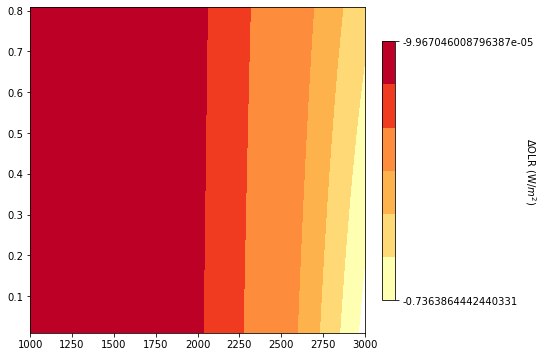

In [7]:
### definitely need revision, read Yang and Seidel
### assume most OLR change come from night side (no cloud?)
fig = plt.figure(figsize = (6,6))

### plot heatmap
#ax = plt.subplot(1,1,1)

matrix = (OLR_day_WBG  - OLR_day_WTG ) #+ OLR_night_WBG  - OLR_night_WTG)
vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf(so, RH3, matrix,  extend = [0.01,1000,0.81,3000], origin = 'lower', cmap = cmap, norm = norm)


cax1 = fig.add_axes([0.94,0.2,0.03,0.6])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='vertical')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(vmin),str((vmax))])
cb1.set_label('$\Delta$OLR (W/$m^2$)',rotation=270)


#plt.colorbar()
#plt.savefig("WTG_WBG_compare_T1-T4.png")
#plt.close()

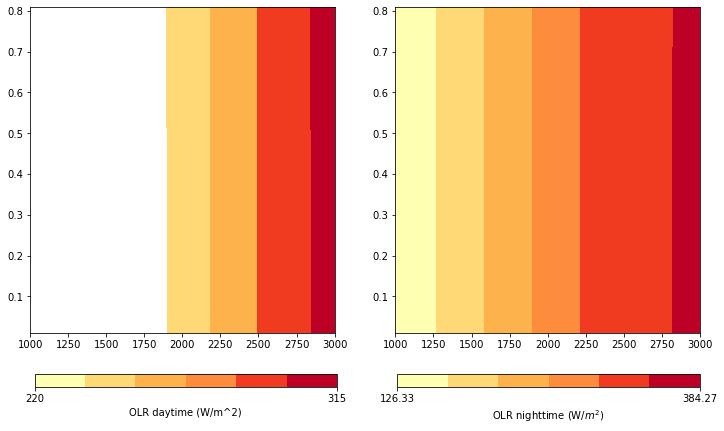

In [8]:
### definitely need revision, read Yang and Seidel
### assume most OLR change come from night side (no cloud?)
fig = plt.figure(figsize = (12,6))

### plot heatmap
ax = plt.subplot(1,2,1)

matrix = (OLR_day_WBG ) #+ OLR_night_WBG  - OLR_night_WTG)
vmin, vmax = 220, 315#np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf(so, RH3, matrix,  extend = [0.01,1000,0.81,3000], origin = 'lower', cmap = cmap, norm = norm)


cax1 = fig.add_axes([0.13,0.0,0.35,0.03])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='horizontal')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('OLR daytime (W/m^2)',rotation=0)


ax = plt.subplot(1,2,2)

matrix = (OLR_night_WBG ) #+ OLR_night_WBG  - OLR_night_WTG)
vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf(so, RH3, matrix,  extend = [0.01,1000,0.81,3000], origin = 'lower', cmap = cmap, norm = norm)


cax1 = fig.add_axes([0.55,0.,0.35,0.03])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='horizontal')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('OLR nighttime (W/$m^2$)',rotation=0)


#plt.colorbar()
#plt.savefig("WTG_WBG_compare_T1-T4.png")
#plt.close()

### Now let's convert to T as x-axis

In [9]:
# calculate matrix for heatmap
nrh = 100
nso = 100
nt = 100
RH3 = np.linspace(0.05,0.8,nrh)
so = np.linspace(1000,4000,nso)
tmpc = np.linspace(280, 320, nt)
xlab = 'Stellar Flux' 
xunit = '(W/$m^2$)'
ylab = 'Relative Humidity' 
yunit = ''



fig = plt.figure(figsize = (12,10))
for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
    OLR_day_matrix = np.zeros((nrh, nso))
    OLR_night_matrix = np.zeros((nrh, nso))
    T1_matrix = np.zeros((nrh, nso))
    T4_matrix = np.zeros((nrh, nso))

    nele = len(RH3)
    initial_guess = (250,250,200,200,200,20)
    for irh,rh in enumerate(RH3):
        #print(idx,s)
        for iso,s in enumerate(so):
            T1, T2, T3, T4, Fa, Fc,fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night= universal_func(So = s, RH3 = rh, assumption  = assumption, p_guess = initial_guess)
            OLR_day_matrix[irh, iso] = OLR_day
            OLR_night_matrix[irh, iso] = OLR_night
            T1_matrix[irh, iso] = T1
            T4_matrix[irh, iso] = T4
            initial_guess = (T1, T2, T3, T4, Fa, Fc)
    if i_assump == 0:
        OLR_day_WTG = OLR_day_matrix
        T1_WTG = T1_matrix
        T4_WTG = T4_matrix
        OLR_night_WTG = OLR_night_matrix
    elif i_assump == 1:
        OLR_day_WBG = OLR_day_matrix
        OLR_night_WBG = OLR_night_matrix
        T1_WBG = T1_matrix
        T4_WBG = T4_matrix

    #nele = len(arr_list)
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    #unit_list = [r'($\frac{W}{m^2}$)',r'($\frac{W}{m^2}$)','','', '','']


We have a solution:  (196.42150953587057, 170.24722190314637, 170.24722190314637, 202.74311756702824, 76.33407842464942, 211.05726801560175)
We have a solution:  (198.83726678329475, 172.3423870686143, 172.3423870686143, 203.94739465098235, 80.16165645117931, 215.0689610282909)
We have a solution:  (201.16626074024686, 174.36276304141504, 174.36276304141504, 205.1300879108901, 83.98720888492434, 219.05124600446126)
We have a solution:  (203.41518727441292, 176.31424066348492, 176.31424066348492, 206.29206148900843, 87.8107375961132, 223.00540505770192)
We have a solution:  (205.58993528337092, 178.20202241649832, 178.20202241649832, 207.434132174817, 91.6322644343864, 226.93268127249414)
We have a solution:  (207.6957094582782, 180.03072916348938, 180.03072916348938, 208.55707333372132, 95.45183112334661, 230.83428771079355)
We have a solution:  (209.7371299910769, 181.80448681658493, 181.80448681658493, 209.66161840497264, 99.26949922296093, 234.71141544373873)
We have a solution:  (2

We have a solution:  (285.2762532365006, 260.8622836381018, 260.8622836381018, 269.2218673972999, 412.5509306998536, 543.4602463331678)
We have a solution:  (285.7752355839937, 261.59934499637575, 261.59934499637575, 269.7937674686413, 416.7436529135075, 547.5267449661468)
We have a solution:  (286.27410762952996, 262.3366587423473, 262.3366587423473, 270.3629891811924, 420.94087976378927, 551.5749196146505)
We have a solution:  (286.77329751681, 263.0745781423262, 263.0745781423262, 270.9296059133346, 425.14273533278975, 555.6030463055404)
We have a solution:  (287.2732486546604, 263.8134804032118, 263.8134804032118, 271.4936954775484, 429.3493752499017, 559.6093058224923)
We have a solution:  (287.77442232313626, 264.55376976352534, 264.55376976352534, 272.05534045113757, 433.56099007425746, 563.5917711168529)
We have a solution:  (288.2773007867415, 265.2958811044495, 265.2958811044495, 272.6146290377471, 437.7778094776282, 567.5483925895825)
We have a solution:  (288.7823912210598,

We have a solution:  (196.42151067361556, 170.24722289009193, 170.24722289009193, 202.74311794643125, 76.3340772185827, 211.0572667621085)
We have a solution:  (198.83726840721357, 172.34238847717347, 172.34238847717347, 203.94739500195521, 80.16165458619184, 215.06895898879222)
We have a solution:  (201.16626305137365, 174.36276504655905, 174.36276504655905, 205.13008842003845, 83.98720614186914, 219.0512430056343)
We have a solution:  (203.41519050054734, 176.31424346338835, 176.31424346338835, 206.29206221267526, 87.81073364500116, 223.0054007393498)
We have a solution:  (205.58993970861448, 178.20202625860128, 178.20202625860128, 207.43413318456066, 91.6322588498449, 226.93267517045672)
We have a solution:  (207.69571543246582, 180.03073435291566, 180.03073435291566, 208.557074719211, 95.45182336474706, 230.8342792353907)
We have a solution:  (209.73713794003467, 181.80449372537794, 181.80449372537794, 209.66162027722154, 99.26948861195088, 234.71140385546565)
We have a solution:  

We have a solution:  (196.4215112347323, 170.24722338067457, 170.24722338067457, 202.74311863824005, 76.33407660282903, 211.05726604702159)
We have a solution:  (198.8372692191732, 172.3423891814533, 172.3423891814533, 203.94739517744168, 80.1616536536978, 215.06895796904254)
We have a solution:  (201.16626420693746, 174.36276604913147, 174.36276604913147, 205.13008867461232, 83.9872047703407, 219.05124150622015)
We have a solution:  (203.41519211361546, 176.31424486334095, 176.31424486334095, 206.2920625745093, 87.81073166944381, 223.00539858017243)
We have a solution:  (205.58994192123808, 178.20202817965438, 178.20202817965438, 207.43413368943274, 91.63225605757148, 226.93267211943535)
We have a solution:  (207.695718419563, 180.03073694763174, 180.03073694763174, 208.55707541195676, 95.45181948544254, 230.83427499768428)
We have a solution:  (209.73714191451955, 181.80449717977962, 181.80449717977962, 209.66162121334733, 99.26948330643752, 234.71139806131993)
We have a solution:  (

We have a solution:  (196.42151206860197, 170.24722409832833, 170.24722409832833, 202.74311830150853, 76.33407566872096, 211.0572650814617)
We have a solution:  (198.83727043711326, 172.34239023787347, 172.34239023787347, 203.9473954406718, 80.16165225495652, 215.06895643941746)
We have a solution:  (201.16626594028412, 174.36276755299087, 174.36276755299087, 205.13008905647382, 83.98720271304758, 219.0512392570979)
We have a solution:  (203.41519453321914, 176.31424696327105, 176.31424696327105, 206.29206311725977, 87.81072870610608, 223.00539534140435)
We have a solution:  (205.58994524017606, 178.20203106123626, 178.20203106123626, 207.43413444674184, 91.63225186915837, 226.93266754289965)
We have a solution:  (207.69572290021313, 180.0307408397096, 180.0307408397096, 208.5570764510762, 95.45181366647991, 230.83426864111814)
We have a solution:  (209.7371478762542, 181.80450236138861, 181.80450236138861, 209.66162261753792, 99.26947534815692, 234.71138937009016)
We have a solution: 

We have a solution:  (196.42151262142247, 170.24722456923342, 170.24722456923342, 202.74311823559503, 76.33407503686243, 211.0572644858475)
We have a solution:  (198.83727124907335, 172.34239094215363, 172.34239094215363, 203.94739561615842, 80.16165132246176, 215.0689554196671)
We have a solution:  (201.16626709584895, 174.36276855556412, 174.36276855556412, 205.13008931104832, 83.98720134151806, 219.0512377576824)
We have a solution:  (203.41519614628916, 176.31424836322523, 176.31424836322523, 206.2920634790938, 87.81072673054655, 223.00539318222434)
We have a solution:  (205.58994745280287, 178.2020329822921, 178.2020329822921, 207.43413495161508, 91.63224907688065, 226.93266449187362)
We have a solution:  (207.69572588731606, 180.0307434344307, 180.0307434344307, 208.55707714382322, 95.45180978716755, 230.8342644034031)
We have a solution:  (209.73715185074897, 181.80450581579885, 181.80450581579885, 209.66162355366617, 99.26947004262944, 234.71138357592915)
We have a solution:  (

We have a solution:  (263.1775593352621, 231.60676751410034, 231.60676751410034, 245.70440413376667, 261.0081826477726, 391.53994369642714)
We have a solution:  (263.9588951301677, 232.49220621952352, 232.49220621952352, 246.41119605781944, 264.9804001124405, 395.4685916988648)
We have a solution:  (264.7250635749826, 233.37033504626638, 233.37033504626638, 247.1134782923755, 268.9605926424625, 399.41434426840544)
We have a solution:  (265.47652199328286, 234.24138103539192, 234.24138103539192, 247.81132836777127, 272.94869378181977, 403.3769504034101)
We have a solution:  (266.2137275159715, 235.10556291074073, 235.10556291074073, 248.5048190660939, 276.94461900983646, 407.35609149250143)
We have a solution:  (266.93713664101966, 235.96309197903733, 235.96309197903733, 249.19401886306355, 280.9482670965146, 411.35138460145737)
We have a solution:  (267.6472047862432, 236.81417299203684, 236.81417299203684, 249.87899235664023, 284.95952149980195, 415.36238584014677)
We have a solution:

We have a solution:  (196.42151329886195, 170.24722512584657, 170.24722512584657, 202.74311832879667, 76.33407421314557, 211.05726394945972)
We have a solution:  (198.8372722640238, 172.3423918225042, 172.3423918225042, 203.94739583551683, 80.16165015684324, 215.0689541449789)
We have a solution:  (201.16626854030537, 174.36276980878105, 174.36276980878105, 205.13008962926656, 83.98719962710541, 219.0512358834125)
We have a solution:  (203.4151981626276, 176.31425011316878, 176.31425011316878, 206.29206393138676, 87.81072426109574, 223.00539048324808)
We have a solution:  (205.58995021858826, 178.20203538361358, 178.20203538361358, 207.43413558270657, 91.63224558653116, 226.93266067808838)
We have a solution:  (207.6957296211979, 180.03074667783483, 180.03074667783483, 208.55707800975782, 95.45180493802272, 230.83425910625465)
We have a solution:  (209.73715681887285, 181.80451013381648, 181.80451013381648, 209.66162472382788, 99.26946341071212, 234.71137633321965)
We have a solution: 

We have a solution:  (196.42151386456206, 170.24722562761775, 170.24722562761775, 202.74311841973994, 76.33407360942907, 211.05726316707768)
We have a solution:  (198.83727307598443, 172.34239252678486, 172.34239252678486, 203.9473960110039, 80.16164922434824, 215.06895312522803)
We have a solution:  (201.16626969587116, 174.36277081135512, 174.36277081135512, 205.13008988384092, 83.98719825557507, 219.0512343839958)
We have a solution:  (203.4151997756991, 176.31425151312428, 176.31425151312428, 206.29206429322105, 87.81072228553408, 223.005388324066)
We have a solution:  (205.58995243121817, 178.2020373046721, 178.2020373046721, 207.4341360875803, 91.63224279424985, 226.932657627058)
We have a solution:  (207.69573260830597, 180.03074927256037, 180.03074927256037, 208.55707870250606, 95.45180105870325, 230.8342548685319)
We have a solution:  (209.73716079337652, 181.80451358823453, 181.80451358823453, 209.66162565995822, 99.26945810517218, 234.7113705390452)
We have a solution:  (211

We have a solution:  (262.38494469958437, 230.7186246130752, 230.7186246130752, 244.99489050870477, 257.0323074493941, 387.6176238909299)
We have a solution:  (263.18228377856326, 231.61209146899154, 231.61209146899154, 245.70647311936955, 260.99532837026635, 391.52797964202256)
We have a solution:  (263.9640243826561, 232.49805216005075, 232.49805216005075, 246.41348085766316, 264.9662758438295, 395.4555487909589)
We have a solution:  (264.7306250675, 233.3767457060632, 233.3767457060632, 247.11599770047346, 268.9450966288825, 399.40014710039674)
We have a solution:  (265.4825447073774, 234.24840202533676, 234.24840202533676, 247.8141024902144, 272.9317178075214, 403.3615193025059)
We have a solution:  (266.2202420843336, 235.11324288188007, 235.11324288188007, 248.507869390452, 276.9260480644245, 407.339342219617)
We have a solution:  (266.94417545712435, 235.97148279530492, 235.97148279530492, 249.1973683308577, 280.92797902592747, 411.3332280164692)
We have a solution:  (267.654802

We have a solution:  (196.4215147159024, 170.2472263863747, 170.2472263863747, 202.7431186221895, 76.33407271294217, 211.05726194418574)
We have a solution:  (198.83727429392562, 172.34239358320605, 172.34239358320605, 203.94739627423417, 80.16164782560509, 215.06895159560125)
We have a solution:  (201.16627142922036, 174.36277231521674, 174.36277231521674, 205.13009026570316, 83.98719619827858, 219.05123213487005)
We have a solution:  (203.4152021953078, 176.3142536130587, 176.3142536130587, 206.29206483597295, 87.81071932219001, 223.0053850852909)
We have a solution:  (205.5899557501651, 178.2020401862618, 178.2020401862618, 207.43413684489158, 91.63223860582434, 226.9326530505092)
We have a solution:  (207.69573708897238, 180.0307531646524, 180.0307531646524, 208.5570797416296, 95.4517952397182, 230.8342485119415)
We have a solution:  (209.73716675513938, 181.80451876986803, 181.80451876986803, 209.66162706415577, 99.26945014685158, 234.71136184777205)
We have a solution:  (211.7183

We have a solution:  (283.96170446999434, 258.9245867883166, 258.9245867883166, 267.6058517620175, 399.3778824556936, 530.6362058919198)
We have a solution:  (284.4766340944189, 259.6827116130776, 259.6827116130776, 268.19441372222246, 403.5165800727955, 534.7074448693813)
We have a solution:  (284.99125566860954, 260.44159975051684, 260.44159975051684, 268.7806437683071, 407.6571612427692, 538.7614879264163)
We have a solution:  (285.5060644947086, 261.2016750457359, 261.2016750457359, 269.3646456048928, 411.7995347895584, 542.7964397437845)
We have a solution:  (286.0215771494511, 261.96339393524903, 261.96339393524903, 269.94653041700036, 415.9436248730935, 546.8102859182735)
We have a solution:  (286.5383354443247, 262.7272500277389, 262.7272500277389, 270.52641794248495, 420.08937261089017, 550.8008754065171)
We have a solution:  (287.0569109113451, 263.4937795066367, 263.4937795066367, 271.10443747495094, 424.2367378945453, 554.7659001316546)
We have a solution:  (287.57791051668

We have a solution:  (290.29593827669675, 268.26252626203103, 268.26252626203103, 274.573031974857, 449.00322926728387, 577.7000469355348)
We have a solution:  (290.85175714906796, 269.074489705869, 269.074489705869, 275.145162662635, 453.152952729372, 581.3854325271066)
We have a solution:  (291.41653838074865, 269.89679480768535, 269.89679480768535, 275.71729082166365, 457.3043750043806, 585.014579649723)
We have a solution:  (291.99167076429035, 270.73102278568933, 270.73102278568933, 276.2897894036073, 461.45776432877307, 588.5812732082575)
We have a solution:  (292.57875851595, 271.5790219255637, 271.5790219255637, 276.8630932516966, 465.61347322391634, 592.0782884609858)
We have a solution:  (293.1796791882248, 272.44297815588897, 272.44297815588897, 277.4377155798021, 469.7719608233904, 595.4971235584942)
We have a solution:  (196.42151587138287, 170.2472273587589, 170.2472273587589, 202.7431180750999, 76.33407118645151, 211.0572611146773)
We have a solution:  (198.8372761208382

We have a solution:  (285.0341449622811, 260.5048919088356, 260.5048919088356, 268.8073312744578, 407.5162271919637, 538.6382442155319)
We have a solution:  (285.5521112142054, 261.269693409514, 261.269693409514, 269.39326011696625, 411.6491491448133, 542.6632304495434)
We have a solution:  (286.0710505251179, 262.03651599443987, 262.03651599443987, 269.9772107372024, 415.7831931770439, 546.6661462155779)
We have a solution:  (286.59153482258444, 262.80589223730874, 262.80589223730874, 270.5593152514147, 419.9182603348868, 550.6447204120711)
We have a solution:  (287.1141702931124, 263.5784029952235, 263.5784029952235, 271.13971696657893, 424.05426692712143, 554.5965057706494)
We have a solution:  (287.63960403760706, 264.3546849700428, 264.3546849700428, 271.7185723751613, 428.1911463316826, 558.5188493645439)
We have a solution:  (288.16853134033806, 265.1354398257787, 265.1354398257787, 272.29605333577473, 432.32885156797715, 562.4088594896488)
We have a solution:  (288.701705157361

We have a solution:  (271.0418358349588, 241.01600040672523, 241.01600040672523, 253.25739936956703, 305.03738474982595, 435.5586302444774)
We have a solution:  (271.68342694973256, 241.8355068501096, 241.8355068501096, 253.9195282780776, 309.08383044577266, 439.64581153956067)
We have a solution:  (272.31493665331044, 242.6501035148921, 242.6501035148921, 254.57790568328303, 313.1362479890734, 443.74378220808404)
We have a solution:  (272.9368069670063, 243.45998391199555, 243.45998391199555, 255.23258464167182, 317.19441909681166, 447.85169949255084)
We have a solution:  (273.54947674540097, 244.265342222033, 244.265342222033, 255.8836177431685, 321.25812079458166, 451.9686839334134)
We have a solution:  (274.1533816709985, 245.06637395858394, 245.06637395858394, 256.53105738827566, 325.3271264831868, 456.0938211156949)
We have a solution:  (274.7489543137639, 245.86327663085228, 245.86327663085228, 257.17495605315423, 329.40120694615933, 460.2261631189657)
We have a solution:  (275.

We have a solution:  (260.74896877103583, 228.91614911598634, 228.91614911598634, 243.560684065009, 249.1109420492834, 379.83061624075464)
We have a solution:  (261.579540634225, 229.82620757665742, 229.82620757665742, 244.28202524988677, 253.056029606209, 383.7045360212417)
We have a solution:  (262.39364615298985, 230.72832087035613, 230.72832087035613, 244.99863698215225, 257.00891723309894, 387.59568425455865)
We have a solution:  (263.1917448053785, 231.62275414416095, 231.62275414416095, 245.71061716818608, 260.96958329940634, 391.50402012525177)
We have a solution:  (263.9742972445555, 232.50976172302157, 232.50976172302157, 246.41805777473948, 264.9379836016801, 395.42942573035685)
We have a solution:  (264.741764991882, 233.38958814728642, 233.38958814728642, 247.1210453027699, 268.9140524318894, 399.3717087078487)
We have a solution:  (265.4946100782249, 234.26246917485116, 234.26246917485116, 247.81966125687137, 272.897703744669, 403.3306051087732)
We have a solution:  (266.

We have a solution:  (239.9727203909138, 208.49200907019622, 208.49200907019622, 227.91871730400285, 171.66500459924785, 305.3164463156818)
We have a solution:  (241.23048050885225, 209.64406834614783, 209.64406834614783, 228.76813116114522, 175.48632876609284, 308.959872096773)
We have a solution:  (242.46196126552042, 210.77867144420526, 210.77867144420526, 229.60898397229766, 179.31109591119557, 312.6052723226803)
We have a solution:  (243.66779805249647, 211.89658289119933, 211.89658289119933, 230.44157094246202, 183.1396720028598, 316.25394960259445)
We have a solution:  (244.848591089754, 212.99852476551268, 212.99852476551268, 231.2661751906423, 186.97241898930704, 319.90718047319535)
We have a solution:  (246.00491032236445, 214.08517939385248, 214.08517939385248, 232.08306790586516, 190.8096923697262, 323.5662091652455)
We have a solution:  (247.13729989947743, 215.1571917989433, 215.1571917989433, 232.8925084955285, 194.65183878849496, 327.2322413610142)
We have a solution:  

We have a solution:  (220.83750423452906, 191.4775760166542, 191.4775760166542, 215.9394164180101, 122.14120836205606, 257.52530785583696)
We have a solution:  (222.5229081517926, 192.95294560295744, 192.95294560295744, 216.932983468288, 125.9488830462965, 261.2638145100188)
We have a solution:  (224.167332974887, 194.39501232409071, 194.39501232409071, 217.9129118603766, 129.75584754696325, 264.9872738861008)
We have a solution:  (225.77259052570977, 195.80556644361022, 195.80556644361022, 218.87968800392485, 133.56233803515372, 268.6969158719841)
We have a solution:  (227.3403308558038, 197.18626603285543, 197.18626603285543, 219.8337793642331, 137.36860880710674, 272.3939887559279)
We have a solution:  (228.872059148472, 198.53865056946614, 198.53865056946614, 220.77563555554443, 141.17493154704115, 276.07975949766967)
We have a solution:  (230.36915069504983, 199.86415274203574, 199.86415274203574, 221.7056893044251, 144.98159442206997, 279.7555133013506)
We have a solution:  (231.

We have a solution:  (248.24677988182535, 216.21564857543328, 216.21564857543328, 233.69491095319194, 198.49810345161228, 330.9053083592678)
We have a solution:  (249.3329198107942, 217.2602356543424, 217.2602356543424, 234.49020227068164, 202.35083832716757, 334.5886304037774)
We have a solution:  (250.396652235816, 218.29191990777576, 218.29191990777576, 235.27875320014917, 206.20939340093608, 338.2822660555724)
We have a solution:  (251.4384554936718, 219.31121842531286, 219.31121842531286, 236.06077786075645, 210.07405606467628, 341.9872065411362)
We have a solution:  (252.45879881957953, 220.31862068912895, 220.31862068912895, 236.83647947911922, 213.94509422883928, 345.7043764812677)
We have a solution:  (253.4581446335915, 221.3145901642494, 221.3145901642494, 237.60605062646152, 217.82275470877883, 349.4346295126504)
We have a solution:  (254.43695050873194, 222.29956581543465, 222.29956581543465, 238.3696734839197, 221.7072618289507, 353.178744470691)
We have a solution:  (255

We have a solution:  (276.51687486509303, 248.2682724122869, 248.2682724122869, 259.1015360204553, 341.5636094509676, 472.58426711372954)
We have a solution:  (277.0852855540027, 249.05359806719196, 249.05359806719196, 259.73305959786404, 345.64900342597434, 476.7300061984878)
We have a solution:  (277.64761605651864, 249.83604113772603, 249.83604113772603, 260.361401834559, 349.7378805104097, 480.8773478836937)
We have a solution:  (278.20429550847285, 250.61584037209659, 250.61584037209659, 260.9866264623038, 353.8299874462408, 485.02512055945635)
We have a solution:  (278.75575337487385, 251.3932429900264, 251.3932429900264, 261.6087994102963, 357.92507216011506, 489.1721156010575)
We have a solution:  (279.30242025544123, 252.16850576604378, 252.16850576604378, 262.2279891039494, 362.0228842205959, 493.31708524530035)
We have a solution:  (279.8447288102663, 252.9418962183641, 252.9418962183641, 262.84426678318516, 366.1231752467814, 497.458739877979)
We have a solution:  (280.3831

We have a solution:  (215.51446761334634, 186.83143161103806, 186.83143161103806, 212.87171233654396, 110.71181954101624, 246.20742890835714)
We have a solution:  (217.3356070879395, 188.4190286508793, 188.4190286508793, 213.90932391713406, 114.52284521593944, 249.998283221613)
We have a solution:  (219.10915612493943, 189.96698957840744, 189.96698957840744, 214.93171111260526, 118.3325642319189, 253.7704959119691)
We have a solution:  (220.8375387249981, 191.47760618429467, 191.47760618429467, 215.93942523811774, 122.14115513502313, 257.52524987527687)
We have a solution:  (222.52295075323542, 192.9529829274568, 192.9529829274568, 216.93299450069594, 125.94881587422461, 261.2637413912339)
We have a solution:  (224.1673851829997, 194.3950581520734, 194.3950581520734, 217.91292554991256, 129.7557634917311, 264.98718246554665)
We have a solution:  (225.77265403775237, 195.805622313096, 195.805622313096, 218.87970486433073, 133.5622336843179, 268.6968024866429)
We have a solution:  (227.3

We have a solution:  (264.7495764225062, 233.39859467055632, 233.39859467055632, 247.1245856192824, 268.89227996216437, 399.35176676430893)
We have a solution:  (265.5030717166777, 234.27233622252953, 234.27233622252953, 247.82356077284905, 272.8738444371526, 403.3089237756618)
We have a solution:  (266.2424501089141, 235.13942949035956, 235.13942949035956, 248.51827187128984, 276.8627226734774, 407.2822418538608)
We have a solution:  (266.96817602480246, 236.00010019807536, 236.00010019807536, 249.2087939131977, 280.858781342338, 411.27131601128355)
We have a solution:  (267.6807133619663, 236.85456836303453, 236.85456836303453, 249.8951983712641, 284.86187009731947, 415.27567859143)
We have a solution:  (268.38052510005997, 237.70304917851104, 237.70304917851104, 250.5775536241363, 288.8718229039562, 419.29480246770197)
We have a solution:  (269.06807293179287, 238.54575386607692, 238.54575386607692, 251.25592537335413, 292.888459372071, 423.3281042025079)
We have a solution:  (269.7

We have a solution:  (196.42151952472622, 170.2472306036074, 170.2472306036074, 202.7431199885907, 76.3340675124947, 211.05725571729857)
We have a solution:  (198.83728119560055, 172.34239956959988, 172.34239956959988, 203.94739776587423, 80.16163989938488, 215.06894292770576)
We have a solution:  (201.16628125154799, 174.36278083711258, 174.36278083711258, 205.13009242959174, 83.98718454024495, 219.05121938980264)
We have a solution:  (203.41521590645297, 176.3142655127127, 176.3142655127127, 206.29206791157443, 87.81070252986791, 223.00536673219054)
We have a solution:  (205.58997455758617, 178.2020565153176, 178.2020565153176, 207.43414113633432, 91.63221487134051, 226.93262711665307)
We have a solution:  (207.69576247951215, 180.0307752199249, 180.0307752199249, 208.55708563001923, 95.45176226533576, 230.8342124911179)
We have a solution:  (209.7372005386303, 181.804548132604, 181.804548132604, 209.6616350213164, 99.26940504946316, 234.71131259696668)
We have a solution:  (211.7184

We have a solution:  (282.5506063652112, 256.85572104557514, 256.85572104557514, 265.9121723304601, 386.5052401602395, 517.9450023743458)
We have a solution:  (283.0793369942222, 257.6291886937566, 257.6291886937566, 266.514738701244, 390.60490715481006, 522.0271341603824)
We have a solution:  (283.607166729882, 258.4034710389245, 258.4034710389245, 267.11515296858687, 394.70471022639543, 526.0944855245801)
We have a solution:  (284.13462567396937, 259.17902198547637, 259.17902198547637, 267.7135374746595, 398.8043790445428, 530.145133162486)
We have a solution:  (284.6622670626224, 259.95633147287856, 259.95633147287856, 268.3100239451084, 402.90364300523987, 534.1770294705819)
We have a solution:  (285.19067162812564, 260.73593069730384, 260.73593069730384, 268.90475480954564, 407.00223080542327, 538.1879840519304)
We have a solution:  (285.72045275116767, 261.5183983050634, 261.5183983050634, 269.4978847693594, 411.0998699239758, 542.1756416499959)
We have a solution:  (286.25226259

We have a solution:  (201.16628298490275, 174.36278234097895, 174.36278234097895, 205.13009281145514, 83.98718248294144, 219.05121714066922)
We have a solution:  (203.4152183260721, 176.31426761265624, 176.31426761265624, 206.29206845432878, 87.81069956651024, 223.0053634934007)
We have a solution:  (205.5899778765524, 178.20205939692403, 178.20205939692403, 207.4341418936501, 91.63221068288937, 226.9326225400764)
We have a solution:  (207.6957669602128, 180.03077911204673, 180.03077911204673, 208.55708666915092, 95.4517564463036, 230.83420613447646)
We have a solution:  (209.73720650045246, 181.80455331428908, 181.80455331428908, 209.66163642552826, 99.26939709105838, 234.7113039056026)
We have a solution:  (211.71841476370483, 183.52708470018652, 183.52708470018652, 210.74848808671075, 103.08521247169372, 238.56509046714794)
We have a solution:  (213.6430749428805, 185.20171073369622, 185.20171073369622, 211.81830473272694, 106.89930209428852, 242.39673187806372)
We have a solution: 

We have a solution:  (259.0442701209438, 227.07925520593963, 227.07925520593963, 242.10647240758598, 241.224526018224, 372.1152639180554)
We have a solution:  (259.9098703394393, 228.00691788790976, 228.00691788790976, 242.83794215739675, 245.15191501013874, 375.95302243239297)
We have a solution:  (260.7581424734378, 228.92614532613905, 228.92614532613905, 243.564500202183, 249.08688930504428, 379.80770540357815)
We have a solution:  (261.589546026457, 229.83723315174524, 229.83723315174524, 244.28626031760615, 253.02946226678347, 383.6794246154852)
We have a solution:  (262.4045422334343, 230.74046432756646, 230.74046432756646, 245.00332954433415, 256.97962222501695, 387.56821001850255)
We have a solution:  (263.2035939320282, 231.63611027396445, 231.63611027396445, 245.71580866709184, 260.9373332430602, 391.47401163129)
We have a solution:  (263.98716534467127, 232.5244319619299, 232.5244319619299, 246.4237926968122, 264.9025360252516, 395.3967018015637)
We have a solution:  (264.75

We have a solution:  (290.20466624872626, 268.12895580588577, 268.12895580588577, 274.2727017965859, 443.50134366823943, 572.5441651016525)
We have a solution:  (290.7943109379636, 268.99068935589645, 268.99068935589645, 274.86707092242364, 447.5547176100405, 576.1341999079656)
We have a solution:  (291.396987419495, 269.8683787102936, 269.8683787102936, 275.4633905511365, 451.60215087660276, 579.6526280776695)
We have a solution:  (292.0149309581965, 270.76469067656996, 270.76469067656996, 276.06236738348076, 455.64301024008074, 583.0897956741259)
We have a solution:  (292.6508382781284, 271.6828728050967, 271.6828728050967, 276.66486099562786, 459.6765774777556, 586.4340024963182)
We have a solution:  (293.30802622709615, 272.6269517128218, 272.6269517128218, 277.2719362762365, 463.7020225595768, 589.6708035423435)
We have a solution:  (293.99066704308643, 273.60202748718837, 273.60202748718837, 277.8849413725931, 467.7183649945803, 592.7819732737562)
We have a solution:  (196.421520

We have a solution:  (251.44165794996525, 219.3143658699142, 219.3143658699142, 236.06190029053133, 210.06672559887318, 341.9797314247693)
We have a solution:  (252.46236159099462, 220.32215473775977, 220.32215473775977, 236.83774898488434, 213.93682165149616, 345.6959898649637)
We have a solution:  (253.46209868619712, 221.31854989652612, 221.31854989652612, 237.6074833090409, 217.81344291280269, 349.42524673974367)
We have a solution:  (254.4413286838397, 222.30399349782112, 222.30399349782112, 238.37128688259082, 221.69680605464768, 353.1682755455086)
We have a solution:  (255.4005079327906, 223.27890485377551, 223.27890485377551, 239.1293333291277, 225.5871036519648, 356.925771564319)
We have a solution:  (256.3400910696295, 224.24368184996868, 224.24368184996868, 239.8817866046487, 229.48450323804792, 360.6983492640189)
We have a solution:  (257.26053214042423, 225.19870231329452, 225.19870231329452, 240.628801354506, 233.38914660304474, 364.4865403383412)
We have a solution:  (25

We have a solution:  (289.6877885448451, 267.37139018783193, 267.37139018783193, 273.7166217156994, 439.25795947670247, 568.7003380057153)
We have a solution:  (290.272095448414, 268.22764005088777, 268.22764005088777, 274.31273961197223, 443.30304782373025, 572.3336580617927)
We have a solution:  (290.86833079797805, 269.0986613878544, 269.0986613878544, 274.9105643610558, 447.3415679926899, 575.9004412577651)
We have a solution:  (291.47853983377365, 269.98688566790105, 269.98688566790105, 275.51074946632707, 451.37279356702516, 579.3919341768429)
We have a solution:  (292.10516780939133, 270.89524982137885, 270.89524982137885, 276.11408321239026, 455.3958970762842, 582.7976178779028)
We have a solution:  (292.7511913652566, 271.8273608177125, 271.8273608177125, 276.7215327222994, 459.40991891759967, 586.1046328687006)
We have a solution:  (293.42031010784405, 272.78773588006686, 272.78773588006686, 277.3343083355006, 463.4137228814676, 589.2969405634844)
We have a solution:  (294.11

We have a solution:  (263.207865852484, 231.64092606547916, 231.64092606547916, 245.717680729173, 260.9257044642978, 391.46319244297223)
We have a solution:  (263.9918052386887, 232.52972233684446, 232.52972233684446, 246.42586103069166, 264.88975243147985, 395.3849020469364)
We have a solution:  (264.76075495070285, 233.41148525510795, 233.41148525510795, 247.12965325040514, 268.8611168492632, 399.3232279685696)
We have a solution:  (265.51518255746674, 234.2864607703504, 234.2864607703504, 247.82914353696236, 272.83968872139155, 403.2778910377085)
We have a solution:  (266.25555612386756, 235.15488763186508, 235.15488763186508, 248.52441376803702, 276.82533868571744, 407.24854242733716)
We have a solution:  (266.9823438358769, 236.01699836121844, 236.01699836121844, 249.215542016373, 280.817918242682, 411.23476669987537)
We have a solution:  (267.69601362503766, 236.8730201949629, 236.8730201949629, 249.90260300484974, 284.8172610168535, 415.23608490716555)
We have a solution:  (268.

We have a solution:  (269.7658644682184, 239.41035357459901, 239.41035357459901, 251.94154877415343, 296.8453004060221, 427.31740669403047)
We have a solution:  (270.4319449176192, 240.24453286697107, 240.24453286697107, 252.61317090521266, 300.8689669549545, 431.3725520389547)
We have a solution:  (271.0872461569282, 241.07373511159588, 241.07373511159588, 253.28107468115113, 304.89828619438896, 435.4395091381768)
We have a solution:  (271.7322290968288, 241.8981758166994, 241.8981758166994, 253.94532422037597, 308.93300731129824, 439.5174768445207)
We have a solution:  (272.36735274237896, 242.71807127140985, 242.71807127140985, 254.60598313329567, 312.9728698468717, 443.60560934357835)
We have a solution:  (272.99307417490877, 243.53363936031954, 243.53363936031954, 255.26311487179072, 317.0176046928763, 447.7030180109455)
We have a solution:  (273.60984860681504, 244.34510038400853, 244.34510038400853, 255.91678306904987, 321.06693501498097, 451.8087729591823)
We have a solution:  

We have a solution:  (247.1405751883424, 215.16030431403163, 215.16030431403163, 232.89358571777993, 194.6447692462728, 327.2248809141508)
We have a solution:  (248.24996577038073, 216.21870013339526, 216.21870013339526, 233.69597514881679, 198.49112339781834, 330.89807586556833)
We have a solution:  (249.33649244898334, 217.26368599567925, 217.26368599567925, 234.49141463230035, 202.342894517386, 334.5804408898408)
We have a solution:  (250.40064750504527, 218.29581170059294, 218.29581170059294, 235.28013090081302, 206.20037920930153, 338.2730224753633)
We have a solution:  (251.44291158806246, 219.31559799722558, 219.31559799722558, 236.06233969771438, 210.06385589462244, 341.97680515725625)
We have a solution:  (252.46375634006944, 220.32353827434366, 220.32353827434366, 236.8382459942459, 213.93358297464488, 345.69270662581226)
We have a solution:  (253.4636466878409, 221.3201001634511, 221.3201001634511, 237.60804423276036, 217.8097971924899, 349.4215733388475)
We have a solution:

We have a solution:  (238.68942255353537, 207.32297162041272, 207.32297162041272, 227.0608565628783, 167.84401505480042, 301.67074351285845)
We have a solution:  (239.97435405959558, 208.49350128266246, 208.49350128266246, 227.91920983153443, 171.66179367819413, 305.3130250790462)
We have a solution:  (241.23235573548425, 209.64579092480554, 209.64579092480554, 228.7687043671681, 175.48258304389782, 308.95589375478403)
We have a solution:  (242.46410557174792, 210.7806531244186, 210.7806531244186, 229.60964871570778, 179.30674398040574, 312.600666052147)
We have a solution:  (243.67024114391154, 211.89885522191605, 211.89885522191605, 230.44233925994308, 183.13463523319928, 316.2486382388489)
We have a solution:  (244.8513649499656, 213.00112232124812, 213.00112232124812, 231.26706039789514, 186.9666110257483, 319.9010802155674)
We have a solution:  (246.00804930827525, 214.08813999900283, 214.08813999900283, 232.084084705379, 190.80301860978688, 323.5592292863307)
We have a solution: 

We have a solution:  (288.0970972916621, 265.03004713558437, 265.03004713558437, 271.99880972222763, 426.7549934372222, 557.149162364487)
We have a solution:  (288.6645626402109, 265.86672936310003, 265.86672936310003, 272.5981199770502, 430.79154708932913, 560.9101502249614)
We have a solution:  (289.2405382807625, 266.71443733680155, 266.71443733680155, 273.1982468887764, 434.8212613401494, 564.6195831881323)
We have a solution:  (289.8265313643897, 267.57492406762503, 267.57492406762503, 273.79967626496534, 438.8433578518898, 568.271181470561)
We have a solution:  (290.42429028619796, 268.4502514021944, 268.4502514021944, 274.402978444721, 442.856962102171, 571.8576073204302)
We have a solution:  (291.03587250255276, 269.3428752842253, 269.3428752842253, 275.0088316862632, 446.8610775902629, 575.370171942028)
We have a solution:  (291.663738210702, 270.2557636673796, 270.2557636673796, 275.61805454525114, 450.8545506195347, 578.7984305139356)
We have a solution:  (292.31088309375286

We have a solution:  (275.4256617821821, 246.77696226440193, 246.77696226440193, 257.8659849516754, 333.19225767690523, 464.1271395817075)
We have a solution:  (276.01222611675263, 247.57588001636606, 247.57588001636606, 258.5071447282694, 337.2533516226513, 468.25326071380675)
We have a solution:  (276.5921724087339, 248.37197615795225, 248.37197615795225, 259.14522407228094, 341.31731161080614, 472.3822725274909)
We have a solution:  (277.1659563618566, 249.16551282817292, 249.16551282817292, 259.780298109023, 345.3838126285329, 476.51298976448294)
We have a solution:  (277.7340352582844, 249.95676204577035, 249.95676204577035, 260.41244476268656, 349.4525248365186, 480.64418338114257)
We have a solution:  (278.2968688719202, 250.74600703935158, 250.74600703935158, 261.0417451614544, 353.52311367353485, 484.7745782013917)
We have a solution:  (278.854920531222, 251.5335437137795, 251.5335437137795, 261.6682840726839, 357.59523984710114, 488.9028498771298)
We have a solution:  (279.40

We have a solution:  (274.96379711006495, 246.54850253841082, 246.62695087065975, 257.8381083985706, 334.2306232320142, 465.70297640843216)
We have a solution:  (275.5294015263464, 247.32561326079775, 247.40993068984045, 258.4734995989199, 338.35507905876636, 469.90028923141216)
We have a solution:  (276.08751494619884, 248.09826500507936, 248.18881342265237, 259.10527029098637, 342.4857720460175, 474.10313323984025)
We have a solution:  (276.6385264212192, 248.86661405874267, 248.96377360503053, 259.73346084855626, 346.6225639481964, 478.3105341052451)
We have a solution:  (277.18281966967464, 249.63081853810758, 249.73498843976535, 260.35811201596607, 350.76532320228574, 482.5215004940347)
We have a solution:  (277.72077328152517, 250.3910388089578, 250.50263827019666, 260.9792650361255, 354.913925789165, 486.73502469718784)
We have a solution:  (278.25276097155285, 251.1474379140441, 251.2669070662308, 261.5969617704037, 359.06825606303954, 490.9500829896664)
We have a solution:  (2

We have a solution:  (196.4213882298932, 170.24725763087937, 170.24726039270973, 202.7431191445126, 76.33414559704552, 211.0574668096551)
We have a solution:  (198.83709516521796, 172.34243741730268, 172.3424415327718, 203.94742596032575, 80.1617549790189, 215.0692515598513)
We have a solution:  (201.1660228473871, 174.36283259582063, 174.36283858791091, 205.13013210106928, 83.98735031242606, 219.05166167999593)
We have a solution:  (203.4148634741976, 176.3143350042896, 176.3143435486272, 206.29212265412608, 87.81093660094616, 223.00598816403382)
We have a solution:  (205.58950177701587, 178.2021482685741, 178.20216022462216, 207.4342153526622, 91.63253944854947, 226.93348475081046)
We have a solution:  (207.69513774090223, 180.03089453228253, 180.03091097826052, 208.5571846425338, 95.4522049817879, 230.83537696013465)
We have a solution:  (209.73638629380665, 181.8047011260215, 181.80472339768616, 209.66176518672708, 99.26999986689928, 234.7128702701937)
We have a solution:  (211.717

We have a solution:  (256.2367656396911, 224.24422450511295, 224.2515994671453, 239.89537121925255, 229.63253629950094, 361.02537105106813)
We have a solution:  (257.1493430460387, 225.1982320425716, 225.20643597061118, 240.64308236608795, 233.55089736423133, 364.841125639866)
We have a solution:  (258.04290659234437, 226.14263840091132, 226.15174678073592, 241.38547250211315, 237.47748450879513, 368.6742632729772)
We have a solution:  (258.9179138831832, 227.0777635958552, 227.0878572601955, 242.122670457423, 241.41241584816447, 372.5251390135194)
We have a solution:  (259.7748239883641, 228.00391033019085, 228.0150757344036, 242.85479651023672, 245.35578404653393, 376.3940205845336)
We have a solution:  (260.6140975567316, 228.9213652099493, 228.93369471666412, 243.58196285241405, 249.3076567854041, 380.2810893842113)
We have a solution:  (261.43619677195676, 229.83039992413495, 229.84399209706893, 244.30427406815755, 253.26807744113196, 384.18644206090175)
We have a solution:  (262.

We have a solution:  (196.42138924514325, 170.24725861655955, 170.24726120080547, 202.7431046523658, 76.3341444377687, 211.05746522571863)
We have a solution:  (198.83709656007227, 172.3424386272146, 172.34244247999487, 203.94742616019732, 80.1617533770831, 215.069249808058)
We have a solution:  (201.1660248384889, 174.3628343233855, 174.36283993300336, 205.13013238916915, 83.98734794917107, 219.05165909646183)
We have a solution:  (203.41486626156376, 176.3143374235355, 176.31434542249252, 206.29212306115588, 87.81093318713683, 223.00598443307518)
We have a solution:  (205.5895056108345, 178.20215159744254, 178.20216279034352, 207.43421591739556, 91.63253461024921, 226.9334794644446)
We have a solution:  (207.69514293010843, 180.03089904028687, 180.03091443653065, 208.55718541331527, 95.45219824241582, 230.83536959862528)
We have a solution:  (209.73639321543646, 181.8047071426753, 181.8047279927602, 209.66176622314134, 99.26999062688346, 234.7128601800565)
We have a solution:  (211.7

We have a solution:  (255.3059891724985, 223.28158502663126, 223.28783449618118, 239.1424913861537, 225.71917256937, 357.22350516706865)
We have a solution:  (256.23816765970463, 224.24568230368754, 224.2526483410335, 239.89569777483672, 229.62908677717365, 361.0219830539087)
We have a solution:  (257.1508861297511, 225.1998540182776, 225.2076031487996, 240.64344920726145, 233.54704871367818, 364.8373731700393)
We have a solution:  (258.0446016003672, 226.14443982968916, 226.15304338239224, 241.38588385352972, 237.4731996823351, 368.6701167330938)
We have a solution:  (258.91977228505186, 227.0797608947906, 227.08929525527992, 242.12313090622132, 241.40765516420876, 372.5205671514903)
We have a solution:  (259.7768578921007, 228.00612112277116, 228.0166679946842, 242.85531102920234, 245.3505050521561, 376.38899042139644)
We have a solution:  (260.61631974095775, 228.92380839405283, 228.93545506911758, 243.58253682403227, 249.3018141133445, 380.2755661339059)
We have a solution:  (261.4

We have a solution:  (196.42139004739747, 170.247259343595, 170.24726178056113, 202.7430860144117, 76.3341435203793, 211.05746420396622)
We have a solution:  (198.83709772245123, 172.34243963547482, 172.3424432693476, 203.94742632675857, 80.16175204213614, 215.0692483482298)
We have a solution:  (201.1660264977412, 174.3628357630236, 174.36284105391425, 205.13013262925244, 83.98734597979127, 219.05165694351578)
We have a solution:  (203.41486858437017, 176.31433943957498, 176.31434698404786, 206.2921234003476, 87.81093034229428, 223.0059813239414)
We have a solution:  (205.58950880568574, 178.2021543715017, 178.2021649284463, 207.434216388007, 91.63253057832969, 226.9334750591366)
We have a solution:  (207.69514725445106, 180.03090279696076, 180.03091731842508, 208.55718605563388, 95.45219262626692, 230.83536346402803)
We have a solution:  (209.73639898346838, 181.80471215655965, 181.80473182199322, 209.66176708682096, 99.26998292686064, 234.71285177159803)
We have a solution:  (211.71

We have a solution:  (255.30726061174147, 223.28289307397228, 223.28877553555114, 239.14278158839858, 225.71608706336096, 357.22045312135697)
We have a solution:  (256.23956992770496, 224.24714038394305, 224.25369740323498, 239.8960243900733, 229.62563655621526, 361.0185944298409)
We have a solution:  (257.1524295138723, 225.20147634009206, 225.20877055852912, 240.6438161226365, 233.54319920415728, 364.8336199375984)
We have a solution:  (258.04629697108084, 226.1462416823153, 226.15434026781566, 241.3862952969248, 237.46891380362547, 368.6659692689812)
We have a solution:  (258.9216311234056, 227.08175871109634, 227.0907335970445, 242.12359146864756, 241.40289319575018, 372.5159941733488)
We have a solution:  (259.77889231953105, 228.0083325449041, 228.01826067721862, 242.85582568807706, 245.34522449504928, 376.3839589149769)
We have a solution:  (260.61854255168834, 228.92625234189842, 228.9372159343588, 243.5831109673637, 249.295969546239, 380.2700412720912)
We have a solution:  (26

We have a solution:  (196.4213909999533, 170.2472602006952, 170.24726246101403, 202.74309071845386, 76.33414241964002, 211.05746309196678)
We have a solution:  (198.83709911730634, 172.34244084538744, 172.3424442165712, 203.94742652662723, 80.1617504401994, 215.0692465964355)
We have a solution:  (201.16602848884477, 174.36283749058995, 174.36284239900775, 205.13013291735263, 83.98734361653437, 219.05165435997927)
We have a solution:  (203.41487137173928, 176.31434185882347, 176.3143488579151, 206.2921238073778, 87.81092692848108, 223.00597759297864)
We have a solution:  (205.58951263950973, 178.20215770037484, 178.20216749417116, 207.4342169527412, 91.63252574002215, 226.9334697727629)
We have a solution:  (207.69515244366707, 180.03090730497368, 180.0309207767014, 208.55718682641657, 95.45218588688138, 230.83535610250397)
We have a solution:  (209.73640590511494, 181.80471817322805, 181.8047364170779, 209.66176812323778, 99.26997368682073, 234.71284168143478)
We have a solution:  (21

We have a solution:  (203.41487369454808, 176.31434387486487, 176.31435041947182, 206.29212414656956, 87.810924083635, 223.00597448384127)
We have a solution:  (205.58951583436524, 178.20216047443762, 178.20216963227654, 207.43421742335343, 91.63252170809588, 226.93346536744812)
We have a solution:  (207.6951567680176, 180.03091106165448, 180.03092365860087, 208.55718746873623, 95.45218027072109, 230.83534996789464)
We have a solution:  (209.73641167316066, 181.80472318712438, 181.80474024631954, 209.66176898691916, 99.26996598677754, 234.7128332729546)
We have a solution:  (211.7173924308806, 183.52730061598498, 183.52732339058218, 210.7486600820223, 103.08596560496436, 238.56710751053444)
We have a solution:  (213.6417751985022, 185.20198194707945, 185.20201195610662, 211.81852513562316, 106.90028650286598, 242.39935874848882)
We have a solution:  (215.51285673174905, 186.83178936443753, 186.83182843184565, 212.87199741112752, 110.71305677929253, 246.21077276099518)
We have a solutio

We have a solution:  (196.42139237877947, 170.2472612543274, 170.24726325194732, 202.7431209079795, 76.33414097341678, 211.05746175388109)
We have a solution:  (198.8371012095899, 172.342442660257, 172.34244563740708, 203.94742682642732, 80.16174803729325, 215.06924396874277)
We have a solution:  (201.1660314755015, 174.36284008194082, 174.36284441664907, 205.1301333495029, 83.98734007164711, 219.05165048467265)
We have a solution:  (203.414875552796, 176.31434548769883, 176.3143516687179, 206.29212441792353, 87.81092180775734, 223.0059719965302)
We have a solution:  (205.58951839025121, 178.20216269368922, 178.20217134276191, 207.43421779984325, 91.63251848255314, 226.93346184319424)
We have a solution:  (207.6951602275007, 180.03091406700145, 180.03092596412216, 208.55718798259232, 95.45217577778922, 230.83534506020314)
We have a solution:  (209.73641628760183, 181.80472719824547, 181.80474330971578, 209.66176967786507, 99.26995982673634, 234.71282654616334)
We have a solution:  (211

We have a solution:  (196.4213931738014, 170.24726194291114, 170.247263793639, 202.74312508601076, 76.33414009012203, 211.0574608089764)
We have a solution:  (198.83710237197013, 172.34244366851843, 172.3424464267608, 203.94742699298484, 80.16174670234517, 215.069242508913)
We have a solution:  (201.16603313475616, 174.3628415215809, 174.36284553756138, 205.13013358958656, 83.98733810226416, 219.0516483317233)
We have a solution:  (203.4148778756069, 176.31434750374208, 176.31435323027603, 206.2921247571156, 87.81091896290877, 223.00596888738994)
We have a solution:  (205.58952158511056, 178.2021654677554, 178.20217348086976, 207.4342182704559, 91.63251445062203, 226.93345743787398)
We have a solution:  (207.6951645518579, 180.030917823688, 180.0309288460258, 208.5571886249129, 95.45217016161969, 230.83533892558376)
We have a solution:  (209.7364220556591, 181.80473221215186, 181.80474713896473, 209.66177054154812, 99.26995212667681, 234.71281813766538)
We have a solution:  (211.717406

We have a solution:  (196.42139381274012, 170.24726250914625, 170.24726424220844, 202.74310756431538, 76.33413936586781, 211.05746005969593)
We have a solution:  (198.83710330187435, 172.3424444751275, 172.34244705824372, 203.9474271262339, 80.16174563438611, 215.06924134104895)
We have a solution:  (201.16603446216024, 174.36284267329333, 174.36284643429153, 205.13013378165363, 83.98733652675725, 219.05164660936327)
We have a solution:  (203.41487973385637, 176.31434911657738, 176.31435447952308, 206.29212502846983, 87.81091668702895, 223.0059664000766)
We have a solution:  (205.5895241409995, 178.2021676870096, 178.2021751913571, 207.43421864694636, 91.63251122507539, 226.93345391361575)
We have a solution:  (207.69516801134628, 180.03092082903953, 180.03093115155045, 208.55718913876964, 95.45216566868044, 230.8353340178843)
We have a solution:  (209.73642667010938, 181.80473622328088, 181.80475020236668, 209.6617712324953, 99.26994596662239, 234.7128114108599)
We have a solution:  (

We have a solution:  (196.4213942890522, 170.24726291081595, 170.24726455587142, 202.74311420101787, 76.33413884914607, 211.05745947791326)
We have a solution:  (198.8371039993027, 172.3424450800845, 172.342447531856, 203.94742722616775, 80.16174483341666, 215.06924046515067)
We have a solution:  (201.16603545771358, 174.36284353707788, 174.36284710683933, 205.13013392570383, 83.98733534512678, 219.05164531759291)
We have a solution:  (203.41488112754388, 176.3143503262042, 176.31435541645854, 206.29212523198524, 87.81091498011821, 223.005964534591)
We have a solution:  (205.5895260579171, 178.20216935145106, 178.20217647422314, 207.43421892931423, 91.63250880591421, 226.93345127042073)
We have a solution:  (207.69517060596414, 180.03092308305455, 180.03093288069488, 208.5571895241623, 95.45216229897383, 230.8353303371073)
We have a solution:  (209.73643013094977, 181.80473923162995, 181.80475249991989, 209.66177175070604, 99.26994134657791, 234.71280636575167)
We have a solution:  (21

We have a solution:  (286.16008584029527, 262.753758653157, 262.92663191627724, 270.6579689982058, 420.7381400636386, 552.4482519100336)
We have a solution:  (286.67396978188003, 263.5178948864112, 263.70180227204844, 271.2401865369073, 424.897745928678, 556.4394004305955)
We have a solution:  (287.19038288484336, 264.285194443248, 264.4808125217477, 271.8208616519589, 429.05873486583465, 560.4022073079107)
We have a solution:  (287.70998117519036, 265.05631284736984, 265.2643679150869, 272.4001636183753, 433.2210619948831, 564.3339598020315)
We have a solution:  (288.23347321292823, 265.8319756315642, 266.0532493774179, 272.9782784261761, 437.38469951208276, 568.2316896420698)
We have a solution:  (288.76163019761634, 266.6129907496976, 266.8483268977709, 273.5554119740254, 441.54963914849657, 572.0921275545546)
We have a solution:  (289.2952987100492, 267.40026390334515, 267.65057606709456, 274.1317936587594, 445.71589466810707, 575.9116457657025)
We have a solution:  (289.8354165190

We have a solution:  (203.41488391492035, 176.31435274545908, 176.31435729033058, 206.29212563901638, 87.81091156629573, 223.0059608036178)
We have a solution:  (205.5895298917544, 178.2021726803358, 178.20217903995652, 207.4342194940503, 91.6325039675886, 226.9334459840275)
We have a solution:  (207.69517579520382, 180.03092759108796, 180.03093633898627, 208.55719029494867, 95.45215555955507, 230.83532297554737)
We have a solution:  (209.73643705263746, 181.80474524833414, 181.8047570950306, 209.66177278712846, 99.26993210647892, 234.71279627552448)
We have a solution:  (211.71742583198127, 183.5273296710365, 183.52734548678603, 210.7486651227246, 103.08591982219285, 238.5670575311087)
We have a solution:  (213.64181861729853, 185.2020197486805, 185.20204058837822, 211.8185317388485, 106.90022545583554, 242.39929212911727)
We have a solution:  (215.51291253364474, 186.83183799585336, 186.83186512615453, 212.87200596273695, 110.71297637411061, 246.21068505227592)
We have a solution:  (

We have a solution:  (286.71357048140385, 263.576759732468, 263.7473852897171, 271.25792980572743, 424.77147701073756, 556.323163872669)
We have a solution:  (287.2329988755307, 264.34847807296967, 264.5300141826204, 271.83997592489186, 428.92428399388234, 560.2760678853664)
We have a solution:  (287.75589121077695, 265.12439211002226, 265.3175225203055, 272.42076459442285, 433.0779255269625, 564.1968716766664)
We have a solution:  (288.282991508287, 265.9052722894768, 266.11073400643625, 273.000495012052, 437.23233883721355, 568.0824610310003)
We have a solution:  (288.81511275931155, 266.691979402629, 266.9105692504325, 273.57938852686425, 441.3874772012678, 571.9293936396238)
We have a solution:  (289.35315120529276, 267.4854818323472, 267.7180642428542, 274.1576927535039, 445.54331190466763, 575.7338349240366)
We have a solution:  (289.89810416051745, 268.2868772161576, 268.5343935594025, 274.7356868259536, 449.6998348450052, 579.4914777872322)
We have a solution:  (290.45109261161

We have a solution:  (196.4213958813139, 170.2472642773284, 170.24726562874486, 202.7431322419718, 76.33413710021118, 211.05745751845146)
We have a solution:  (198.8371063240648, 172.34244709660857, 172.34244911056433, 203.9474275592819, 80.16174216351796, 215.0692375454888)
We have a solution:  (201.16603877622612, 174.36284641636092, 174.3628493486662, 205.13013440587147, 83.98733140635659, 219.0516410116896)
We have a solution:  (203.41488577317216, 176.31435435829636, 176.31435853957905, 206.29212591037083, 87.8109092904127, 223.00595831630122)
We have a solution:  (205.58953244764768, 178.20217489959367, 178.20218075044647, 207.43421987054114, 91.63250074203597, 226.93344245976286)
We have a solution:  (207.69517925469984, 180.03093059644618, 180.03093864451571, 208.55719080880638, 95.45215106660513, 230.83531806783628)
We have a solution:  (209.73644166710088, 181.80474925947462, 181.8047601584409, 209.66177347807752, 99.26992594640555, 234.71278954869857)
We have a solution:  (2

We have a solution:  (196.42139636831823, 170.24726473123022, 170.24726599414325, 202.74311627780423, 76.33413653059368, 211.05745690272911)
We have a solution:  (198.8371070214936, 172.34244770156587, 172.3424495841769, 203.94742765921916, 80.16174136254793, 215.06923666958983)
We have a solution:  (201.16603977178033, 174.36284728014624, 174.36285002121454, 205.13013454992205, 83.9873302247249, 219.05163971991797)
We have a solution:  (203.41488716686146, 176.31435556792474, 176.31435947651573, 206.29212611388638, 87.81090758349981, 223.00595645081304)
We have a solution:  (205.58953436456832, 178.20217656403779, 178.20218203331444, 207.43422015290955, 91.6324983228702, 226.9334398165632)
We have a solution:  (207.69518184932332, 180.03093285046614, 180.0309403736638, 208.5571911941999, 95.45214769689059, 230.83531438705086)
We have a solution:  (209.73644512795116, 181.80475226783227, 181.8047624560003, 209.66177399628958, 99.26992132634668, 234.7127845035749)
We have a solution:  (

We have a solution:  (196.42139733474136, 170.24726557762122, 170.2472666641623, 202.74311692853928, 76.33413546104336, 211.057455650587)
We have a solution:  (198.8371084163516, 172.342448911481, 172.34245053140233, 203.94742785908923, 80.16173976060762, 215.06923491779168)
We have a solution:  (201.16604176288948, 174.3628490077175, 174.3628513663117, 205.1301348380229, 83.98732786146087, 219.0516371363738)
We have a solution:  (203.41488995424126, 176.31435798718255, 176.31436135038982, 206.29212652091823, 87.8109041696724, 223.005952719835)
We have a solution:  (205.58953819841216, 178.20217989292811, 178.20218459905195, 207.43422071764638, 91.63249348453594, 226.9334345301604)
We have a solution:  (207.69518703857435, 180.03093735850953, 180.03094383196245, 208.55719196498765, 95.45214095745578, 230.83530702547375)
We have a solution:  (209.7364520496585, 181.8047582845536, 181.8047670511235, 209.66177503271484, 99.26991208621911, 234.71277441331702)
We have a solution:  (211.7174

We have a solution:  (196.42139765481232, 170.24726585104472, 170.2472668788733, 202.74311852509575, 76.33413511270136, 211.05745525008092)
We have a solution:  (198.83710888130423, 172.34244931478605, 172.34245084714422, 203.94742792571225, 80.16173922662739, 215.06923433385896)
We have a solution:  (201.16604242659278, 174.36284958357476, 174.36285181467758, 205.1301349340566, 83.98732707370597, 219.05163627519207)
We have a solution:  (203.4148908833683, 176.3143587936021, 176.3143619750148, 206.29212665659566, 87.81090303172955, 223.00595147617508)
We have a solution:  (205.58953947636076, 178.20218100255877, 178.20218545429822, 207.43422090589186, 91.63249187175695, 226.93343276802517)
We have a solution:  (207.69518876832592, 180.03093886119163, 180.03094498472942, 208.55719222191723, 95.45213871097592, 230.83530457161288)
We have a solution:  (209.73645435689642, 181.80476029012922, 181.8047685828326, 209.66177537819024, 99.26990900617385, 234.7127710498945)
We have a solution: 

We have a solution:  (201.16604309029614, 174.36285015943213, 174.36285226304352, 205.1301350300904, 83.98732628595097, 219.05163541401035)
We have a solution:  (203.41489181249548, 176.31435960002193, 176.31436259963988, 206.29212679227263, 87.81090189378648, 223.00595023251498)
We have a solution:  (205.58954075430967, 178.20218211218975, 178.20218630954471, 207.43422109413777, 91.6324902589776, 226.93343100588956)
We have a solution:  (207.6951904980781, 180.03094036387432, 180.03094613749678, 208.5571924788465, 95.45213646449527, 230.83530211775104)
We have a solution:  (209.7364566641351, 181.80476229570553, 181.80477011454218, 209.66177572366567, 99.26990592612681, 234.71276768647064)
We have a solution:  (211.71745164206425, 183.5273521227908, 183.52736256121457, 210.74866901783255, 103.08588444438607, 238.56701891041683)
We have a solution:  (213.64185216842037, 185.2020489592126, 185.20206271346186, 211.81853684137414, 106.90017828277362, 242.39924065012832)
We have a solution

We have a solution:  (270.8508739684439, 241.0865225232244, 241.10122750983888, 253.31613231831383, 305.2703207697413, 436.3204292198877)
We have a solution:  (271.4869500413953, 241.9089785697423, 241.92490042219794, 253.98082553182033, 309.32373956115015, 440.43548667361654)
We have a solution:  (272.11308194616043, 242.72660478550554, 242.74382682595547, 254.6418339218955, 313.38286907946963, 444.5611245381217)
We have a solution:  (272.7297248342939, 243.53960085962416, 243.5582110952082, 255.29921431592905, 317.4474613855297, 448.69644438441384)
We have a solution:  (273.3373306088467, 244.34816794259683, 244.36825930087232, 255.9530235335096, 321.51726344254325, 452.84051133108534)
We have a solution:  (273.9363479782782, 245.15250936482443, 245.174179944473, 256.6033186822506, 325.59201810138285, 456.9923556419275)
We have a solution:  (274.5272225846074, 245.95283136199072, 245.97618470044804, 257.2501574435995, 329.6714650105565, 461.150973984782)
We have a solution:  (275.110

We have a solution:  (196.42139904814655, 170.24726697859492, 170.24726774287222, 202.7431406012603, 76.33413351186094, 211.05745400409413)
We have a solution:  (198.83711097359233, 172.34245112965965, 172.34245226798313, 203.94742822551422, 80.16173682371586, 215.0692317061603)
We have a solution:  (201.16604541325833, 174.36285217493324, 174.36285383232453, 205.13013536620807, 83.98732352880715, 219.05163239987317)
We have a solution:  (203.41489506444188, 176.31436242249222, 176.31436478582853, 206.29212726714357, 87.81089791098366, 223.0059458797027)
We have a solution:  (205.58954522713333, 178.20218599590027, 178.20218930290892, 207.43422175299844, 91.63248461424593, 226.9334248384109)
We have a solution:  (207.6951965522149, 180.03094562326757, 180.03095017218538, 208.55719337810064, 95.45212860180638, 230.8352935292283)
We have a solution:  (209.73646473947903, 181.80476931523, 181.804775475531, 209.66177693283095, 99.26989514595112, 234.71275591447403)
We have a solution:  (21

We have a solution:  (196.42139986362136, 170.24726772121633, 170.24726833821856, 202.7431409316501, 76.33413269271408, 211.0574526836092)
We have a solution:  (198.83711213597496, 172.34245213792306, 172.34245305733833, 203.94742839207274, 80.16173548876446, 215.06923024632715)
We have a solution:  (201.16604707251804, 174.3628536145777, 174.36285495324015, 205.13013560629255, 83.98732155941808, 219.05163024691691)
We have a solution:  (203.41489738726213, 176.31436443854363, 176.31436634739268, 206.29212760633703, 87.81089506612274, 223.005942770549)
We have a solution:  (205.5895484220099, 178.2021887699814, 178.20219144102788, 207.43422222361343, 91.63248058229158, 226.93342043306544)
We have a solution:  (207.69520087660283, 180.03094937998083, 180.03095305410852, 208.55719402042538, 95.4521229855937, 230.83528739456236)
We have a solution:  (209.7364705075894, 181.80477432918264, 181.80477930481354, 209.6617777965217, 99.26988744581463, 234.71274750589322)
We have a solution:  (2

We have a solution:  (288.1248436006144, 265.67113488161476, 265.7444110981496, 272.58617190617184, 431.9324598762256, 563.0916524753143)
We have a solution:  (288.68226988299324, 266.4957479947208, 266.5738962727504, 273.1794295193222, 436.0101131242767, 566.8748400792039)
We have a solution:  (289.2479672857889, 267.3305245326514, 267.41389284273237, 273.77316999521327, 440.0831921757075, 570.60693845605)
We have a solution:  (289.82334161646673, 268.17708122285757, 268.26605316532084, 274.3678311617556, 444.1511864177165, 574.2820144013059)
We have a solution:  (290.41001615406924, 269.03731100115033, 269.13231196780714, 274.96392428665615, 448.21353377706083, 577.8931691470594)
We have a solution:  (291.00989109983584, 269.9134570217139, 270.0149619884397, 275.5620537828278, 452.26960693112585, 581.4322786392594)
We have a solution:  (291.6252249533831, 270.8082140957853, 270.9167576469996, 276.1629442448743, 456.3186947133158, 584.8896379253188)
We have a solution:  (292.258748611

We have a solution:  (284.93234333819316, 260.92756719860824, 260.96371644951245, 269.0357203715303, 407.2669183916235, 539.4593460255497)
We have a solution:  (285.46494103479273, 261.7196977491009, 261.75825562360575, 269.6340204137074, 411.35426225093823, 543.4496393792467)
We have a solution:  (286.0003371702889, 262.5161428184801, 262.5572651570443, 270.2312181214733, 415.4388607870733, 547.4113833392124)
We have a solution:  (286.5393131224858, 263.31770762467517, 263.36156253071664, 270.8275369898226, 419.5203088370454, 551.3414861011945)
We have a solution:  (287.0827203421828, 264.12529130125745, 264.17206064438517, 271.4232258150445, 423.59818075192766, 555.2365339290147)
We have a solution:  (287.63149487643597, 264.9399047995497, 264.98978599929313, 272.01856347586687, 427.67202600364277, 559.0927285207746)
We have a solution:  (288.18667554748663, 265.7626933628294, 265.8159015240803, 272.61386494409606, 431.74136373329515, 562.9058084026394)
We have a solution:  (288.7494

We have a solution:  (286.5589398169487, 263.3468879543143, 263.38406048386247, 270.83630849890983, 419.45745561809815, 551.2840529864201)
We have a solution:  (287.1039397774009, 264.15680992815345, 264.19645806075073, 271.43272137417745, 423.5309513180061, 555.1738996808215)
We have a solution:  (287.6544721450771, 264.9739866766112, 265.0162789818, 272.02885234431085, 427.60010454805627, 559.0242828128252)
We have a solution:  (288.2116003977867, 265.7995952265388, 265.8447155255948, 272.6250258997221, 431.6644044647877, 562.8308421477319)
We have a solution:  (288.77651913045105, 266.6349822110184, 266.6831318304985, 273.22161225094516, 435.72329846749494, 566.5886325107007)
We have a solution:  (289.3505852285206, 267.48170263955143, 267.53310317212095, 273.81903776524246, 439.7761824167039, 570.2919887510963)
We have a solution:  (289.9353586769411, 268.34157074611943, 268.39646747573516, 274.4177986706981, 443.82238797525577, 573.9343487901406)
We have a solution:  (290.53265693

We have a solution:  (271.5218592982081, 241.95435482474582, 241.95796118742743, 253.99288847835132, 309.21536269385757, 440.3444226450021)
We have a solution:  (272.1505849926217, 242.7758300707277, 242.77973187452466, 254.6550099128948, 313.265443519652, 444.4630736168781)
We have a solution:  (272.7699919253445, 243.59295677026435, 243.5971741699926, 255.31359123076217, 317.32035315202654, 448.5909304197572)
We have a solution:  (273.3805436529308, 244.40595467061848, 244.4105089718726, 255.96869528385315, 321.37980041674524, 452.72702237226315)
We have a solution:  (273.9827015462893, 245.21504702316798, 245.21996074421662, 256.62038562931394, 325.4434878192346, 456.8703403261398)
We have a solution:  (274.57692502647075, 246.02046144010382, 246.02575837830827, 257.2687268551184, 329.511112297772, 461.01983749783864)
We have a solution:  (275.16367189094433, 246.8224307828951, 246.82813608617158, 257.9137849033177, 333.58236588476666, 465.17442988664504)
We have a solution:  (275.7

We have a solution:  (284.4748876919265, 260.2475853535173, 260.2554565667106, 268.4684023178587, 402.9359605282296, 535.2358158957603)
We have a solution:  (285.01100800564217, 261.04454158319413, 261.05294267523834, 269.07061028307413, 407.0087601592476, 539.2343754763249)
We have a solution:  (285.5497169363276, 261.84580774845693, 261.85477326536875, 269.6717383487086, 411.0780387391793, 543.2053921848703)
We have a solution:  (286.0918020632333, 262.65219375195954, 262.6617609617014, 270.27201414125403, 415.143311982822, 547.1457942633784)
We have a solution:  (286.63812066586394, 263.4646035154889, 263.4748127404382, 270.8716910578302, 419.2040667830335, 551.0521921597706)
We have a solution:  (287.1896141602462, 264.28405284732696, 264.2949478585644, 271.4710531211149, 423.2597553753206, 554.920816891805)
We have a solution:  (287.74732615727555, 265.1116918564559, 265.12332034551724, 272.07042107842005, 427.3097880876858, 558.7474427264178)
We have a solution:  (288.31242533271

We have a solution:  (287.21123530538927, 264.31616051981246, 264.31979910540184, 271.48072488717173, 423.19137813749717, 554.8568984072751)
We have a solution:  (287.770780309055, 265.1464688329656, 265.1503529627039, 272.08091846256434, 427.2365403616468, 558.6774534350714)
We have a solution:  (288.33791874019596, 265.9865588022926, 265.99070604741536, 272.6815687932275, 431.27502953912517, 562.4504588753085)
We have a solution:  (288.9140081410196, 266.8379871278951, 266.8424168249983, 273.28310887501516, 435.3061013888437, 566.1703149042208)
We have a solution:  (289.5006071734244, 267.7025684770518, 267.7073020248487, 273.8860423977084, 439.328926639096, 569.8305411831452)
We have a solution:  (290.09952923392933, 268.58244265666656, 268.58750388902814, 274.4909621751277, 443.3425693109813, 573.4235463297991)
We have a solution:  (290.7129152251354, 269.4801659117473, 269.48558157426737, 275.0985752221665, 447.34595755759113, 576.9403148587762)
We have a solution:  (291.343334600

<Figure size 864x720 with 0 Axes>

<Figure size 432x432 with 0 Axes>

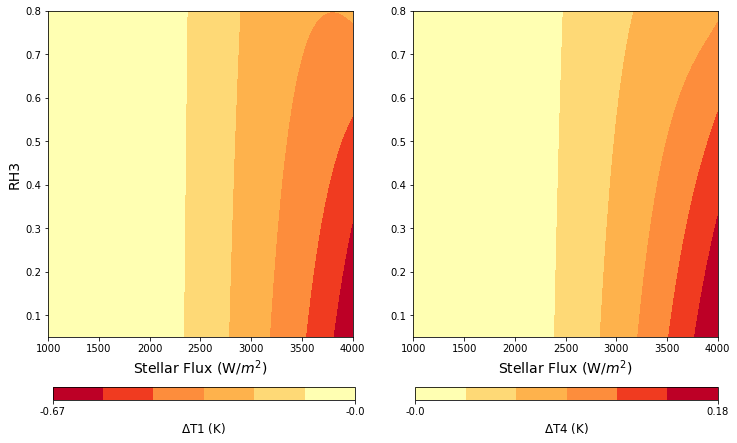

In [10]:
### definitely need revision, read Yang and Seidel
### assume most OLR change come from night side (no cloud?)
fig = plt.figure(figsize = (6,6))
fs = 14

#matrix = T1_WTG
my_type = 'diff'
if my_type == 'diff':
    matrix = T1_WBG - T1_WTG
elif my_type == 'WBG':
    matrix = T1_WBG
elif my_type == 'WTG':
    matrix = T1_WTG

### definitely need revision, read Yang and Seidel
### assume most OLR change come from night side (no cloud?)
fig = plt.figure(figsize = (12,6))

### plot heatmap
ax = plt.subplot(1,2,1)

vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)
colors = np.array(['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026'])[::-1]
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf(so, RH3, matrix, levels = levels, extent = [0.05,1000,0.75,4000], origin = 'lower', cmap = cmap, norm = norm, vmin = vmin, vmax = vmax)
plt.xlabel('Stellar Flux (W/$m^2$)', fontsize = fs)
plt.ylabel('RH3', fontsize = fs)

cax1 = fig.add_axes([0.13,-0.02,0.35,0.03])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='horizontal')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('$\Delta$T1 (K)',rotation=0,fontsize = fs-2)


ax = plt.subplot(1,2,2)


if my_type =='diff':
    matrix = T4_WBG -  T4_WTG
elif my_type == 'WBG':
    matrix = T4_WBG
elif my_type == 'WTG':
    matrix = T4_WTG

vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf(so, RH3, matrix, levels = levels, extent = [0.05,1000,0.75,4000], origin = 'lower', cmap = cmap, norm = norm, vmin = vmin, vmax = vmax)
plt.xlabel('Stellar Flux (W/$m^2$)', fontsize = fs)

cax1 = fig.add_axes([0.55,-0.02,0.35,0.03])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='horizontal')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('$\Delta$T4 (K)',rotation=0, fontsize = fs-2)


#plt.colorbar()
#plt.savefig("WTG_WBG_compare_T1-T4.png")
#plt.close()

In [11]:
np.shape(np.shape(np.tile(RH3[:, np.newaxis], 100)))

(2,)

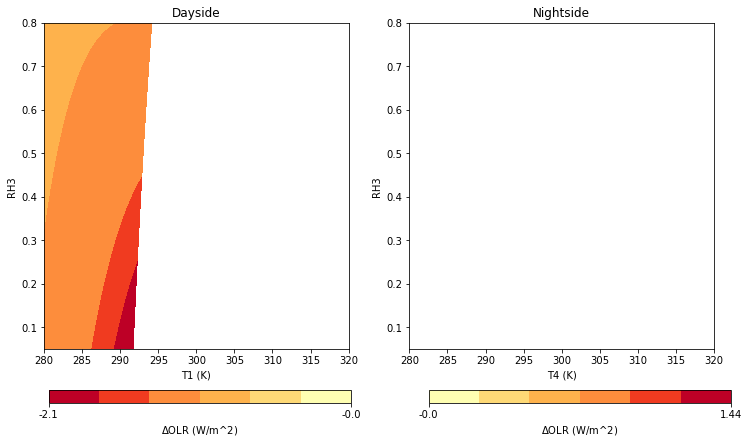

In [12]:
fig = plt.figure(figsize = (12,6))
### plot heatmap
#ax = plt.subplot(1,1,1)

ax  = plt.subplot(1,2,1)
matrix=  (OLR_day_WBG  - OLR_day_WTG)
vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)

colors = np.array(['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026'])[::-1]
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf( T1_matrix, (np.tile(RH3[:, np.newaxis], 100)),  matrix,  extend = [0.01,280,0.81,320], origin = 'lower', cmap = cmap, norm = norm)
plt.xlim(280,320)
plt.title('Dayside')
plt.xlabel('T1 (K)')
plt.ylabel('RH3')
cax1 = fig.add_axes([0.13,0.0,0.35,0.03])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='horizontal')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('$\Delta$OLR (W/m^2)',rotation=0)


ax  = plt.subplot(1,2,2)
matrix=  (OLR_night_WBG  - OLR_night_WTG)
vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)

colors = np.array(['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026'])#[::-1]
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf( T4_matrix, (np.tile(RH3[:, np.newaxis], 100)), matrix,  extend = [0.01,280,0.81,320], origin = 'lower', cmap = cmap, norm = norm)
plt.xlim(280,320)
plt.title('Nightside')
plt.xlabel('T4 (K)')
plt.ylabel('RH3')

cax1 = fig.add_axes([0.57,0.0,0.35,0.03])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='horizontal')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('$\Delta$OLR (W/m^2)',rotation=0)




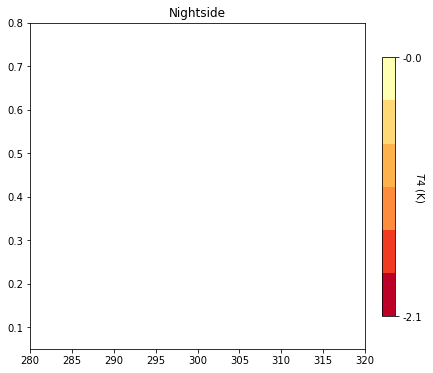

In [13]:
fig = plt.figure(figsize = (6,6))
### plot heatmap
#ax = plt.subplot(1,1,1)

matrix=  (OLR_day_WBG  - OLR_day_WTG)
vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)
levels = np.linspace(vmin, vmax, 7)

colors = np.array(['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026'])[::-1]
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
plt.contourf( T4_matrix, (np.tile(RH3[:, np.newaxis], 100)),  (OLR_night_WBG  - OLR_night_WTG),  extend = [0.01,1000,0.81,3000], origin = 'lower')
plt.xlim(280,320)
plt.title('Nightside')
cax1 = fig.add_axes([0.94,0.2,0.03,0.6])
cb1  = ColorbarBase(cax1,cmap=cmap,orientation='vertical')
cb1.set_ticks([0,1.])
cb1.set_ticklabels([str(round(vmin,2)),str(round(vmax,2))])
cb1.set_label('$T4$ (K)',rotation=270)




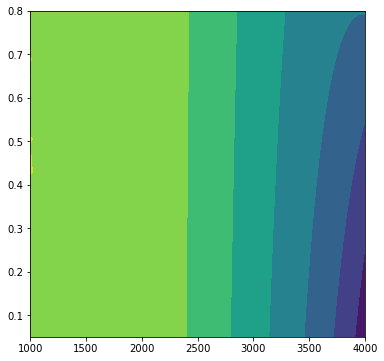

In [14]:
fig = plt.figure(figsize = (6,6))
### plot heatmap
#ax = plt.subplot(1,1,1)

plt.contourf(so, RH3, 0.5*(OLR_day_WBG  - OLR_day_WTG + OLR_night_WBG  - OLR_night_WTG),  extend = [0.01,1000,0.81,3000], origin = 'lower')
#plt.colorbar()
#cbar.set_clim( vmin, vmax )
#plt.colorbar()
#plt.savefig("WTG_WBG_compare_T1-T4.png")
#plt.close()

In [15]:
def plot_heatmap(): 
    
    # calculate matrix for heatmap
    nrh = 100
    nso = 100
    RH3 = np.linspace(0.1,0.8,nrh)
    so = np.linspace(1000,3000,nso)
    xlab = 'Stellar Flux' 
    xunit = '(W/$m^2$)'
    ylab = 'Relative Humidity' 
    yunit = ''

    
    
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        OLR_day_matrix = np.zeros((nrh, nso))
        OLR_night_matrix = np.zeros((nrh, nso))

        nele = len(RH3)
        initial_guess = (250,250,200,200,200,20)
        for irh,rh in enumerate(RH3):
            #print(idx,s)
            for iso,s in enumerate(so):
                T1, T2, T3, T4, Fa, Fc,fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night= universal_func(So = s, RH_3 = rh, assumption  = assumption, p_guess = initial_guess)
                OLR_day_matrix[irh, iso] = OLR_day
                OLR_night_matrix[irh, iso] = OLR_night
                initial_guess = (T1, T2, T3, T4, Fa, Fc)
        if i_assump == 0:
            OLR_day_WTG = OLR_day_matrix
            OLR_night_WTG = OLR_night_matrix
        elif i_assump == 1:
            OLR_day_WBG = OLR_day_matrix
            OLR_night_WBG = OLR_night_matrix
                
        #nele = len(arr_list)
        #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
        #unit_list = [r'($\frac{W}{m^2}$)',r'($\frac{W}{m^2}$)','','', '','']
        
    ### plot heatmap
    ax = plt.subplot(1,2,1)
    ax.set_title('Day')
    ax.contourf(so, RH3, OLR_day_WBG  - OLR_day_WTG,  extend = [0.1,1000,0.8,3000], origin = 'lower')
    ax = plt.subplot(1,2,2)
    ax.set_title('Night')
    ax.contourf(so, RH3,  OLR_night_WBG  - OLR_night_WTG,  extend = [0.1,1000,0.8,3000], origin = 'lower')
        
        
    #plt.savefig("WTG_WBG_compare_T1-T4.png")
    plt.close()

    return fig
plot_heatmap()

TypeError: universal_func() got an unexpected keyword argument 'RH_3'

<Figure size 864x720 with 0 Axes>